# Libraries

In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.interpolate import splprep, splev
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

%config InlineBackend.figure_formats=['retina']

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from SurgeLibrary.stability_selection import StabilitySelection, plot_stability_path
from SurgeLibrary.preprocessing import remove_low_info_samples, LowInfoFilter
from SurgeLibrary.visualization import boxplot_features

# Data

In [5]:
D0_unstim = pd.read_csv('../Data_POCK/Immuno/D0_Unstim&Freq.csv', index_col=0)
D0_unstim.columns = [el[1]+'_'+el[-1] for el in D0_unstim.columns.str.split('_')]
D0 = D0_unstim.copy()
D0.index = [idx + '_D0' for idx in D0.index]
labels_D0 = pd.read_csv('../Data_POCK/Immuno/labels_D0.csv', index_col=0)
# labels_D0.index = [idx + '_D0' for idx in labels_D0.index]

D1_unstim = pd.read_csv('../Data_POCK/Immuno/D1_Unstim&Freq.csv', index_col=0)
D1_unstim.columns = [el[1]+'_'+el[-1] for el in D1_unstim.columns.str.split('_')]
D1 = D1_unstim.copy()
D1.index = [idx + '_D1' for idx in D1.index]
labels_D1 = pd.read_csv('../Data_POCK/Immuno/labels_D1.csv', index_col=0)
# labels_D1.index = [idx + '_D1' for idx in labels_D1.index]

D7_unstim = pd.read_csv('../Data_POCK/Immuno/D7_Unstim&Freq.csv', index_col=0)
D7_unstim.columns = [el[1]+'_'+el[-1] for el in D7_unstim.columns.str.split('_')]
D7 = D7_unstim.copy()
D7.index = [idx + '_D7' for idx in D7.index]
labels_D7 = pd.read_csv('../Data_POCK/Immuno/labels_D7.csv', index_col=0)
# labels_D7.index = [idx + '_D7' for idx in labels_D7.index]

D90_unstim = pd.read_csv('../Data_POCK/Immuno/D90_Unstim&Freq.csv', index_col=0)
D90_unstim.columns = [el[1]+'_'+el[-1] for el in D90_unstim.columns.str.split('_')]
D90 = D90_unstim.copy()
D90.index = [idx + '_D90' for idx in D90.index]
labels_D90 = pd.read_csv('../Data_POCK/Immuno/labels_D90.csv', index_col=0)
# labels_D90.index = [idx + '_D90' for idx in labels_D90.index]

In [6]:
df_tot = pd.concat([D0, D1, D7, D90], axis='rows')

# Effect directions

In [7]:
D0_std = (D0_unstim - D0_unstim.mean())/(D0_unstim.std()+1e-8)
D1_std = (D1_unstim - D1_unstim.mean())/(D1_unstim.std()+1e-8)
D7_std = (D7_unstim - D7_unstim.mean())/(D7_unstim.std()+1e-8)
D90_std = (D90_unstim - D90_unstim.mean())/(D90_unstim.std()+1e-8)

# ANOVA

In [8]:
X_D0 = D0_unstim.join(labels_D0)
X_D0['TimePoint'] = 0
X_D1 = D1_unstim.join(labels_D1)
X_D1['TimePoint'] = 1
X_D7 = D7_unstim.join(labels_D7)
X_D7['TimePoint'] = 2
X_D90 = D90_unstim.join(labels_D90)
X_D90['TimePoint'] = 3

In [9]:
df_anova = pd.concat([X_D0, X_D1, X_D7, X_D90],axis='rows').dropna(subset=['POCD_J7_pos']).reset_index(drop=True)
#df_anova.fillna(df_anova.median(), inplace=True)

In [10]:
df_anova['POCD_J7_pos'] = df_anova.POCD_J7_pos.astype(int)

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
pvalues_anova = pd.DataFrame(index = df_anova.columns[:-2])
for feature in df_anova.columns[:-2]:
    # Ordinary Least Squares (OLS) model
    model = ols(f'{feature} ~ C(POCD_J7_pos)*C(TimePoint)', data=df_anova).fit()
    table = sm.stats.anova_lm(model,typ=1)
    pvalues_anova.loc[feature,'pvalue_anova']=table.loc['C(POCD_J7_pos)', 'PR(>F)']

In [12]:
pvalues_anova = pvalues_anova.fillna(1)

# t-SNE

In [14]:
df_corr = df_tot.corr()

In [15]:
tsne = TSNE(learning_rate='auto', random_state=4).fit(df_tot.fillna(df_tot.median()).T)
df_tsne = pd.DataFrame(data=tsne.embedding_, index = df_tot.columns, columns = ['coor1', 'coor2'])

/Users/gregoirebellan/opt/anaconda3/envs/surge/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [16]:
clusterer = KMeans(n_clusters=10, n_init=100, random_state=42, init='k-means++')
cluster_labels = clusterer.fit_predict(df_tsne[['coor1', 'coor2']])
cen_x, cen_y = clusterer.cluster_centers_.T
df_tsne['cluster'] = cluster_labels

In [17]:
df_tsne = pd.concat([df_tsne, pvalues_anova], axis='columns')

# Correlation Plot

In [18]:
#df_tsne.to_csv('./df_tsne.csv')

In [19]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = [(1, 0, 0), (.7, .4, 0), (0, 0, 1)]  # R -> G -> B
colors = [(0,(0, 0, 1)),(.35,(227/256, 163/256, 103/256)),(.65,(227/256, 163/256, 103/256)), (1,(1, 0, 0))]
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom_cmp'

cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256,gamma=1)

8

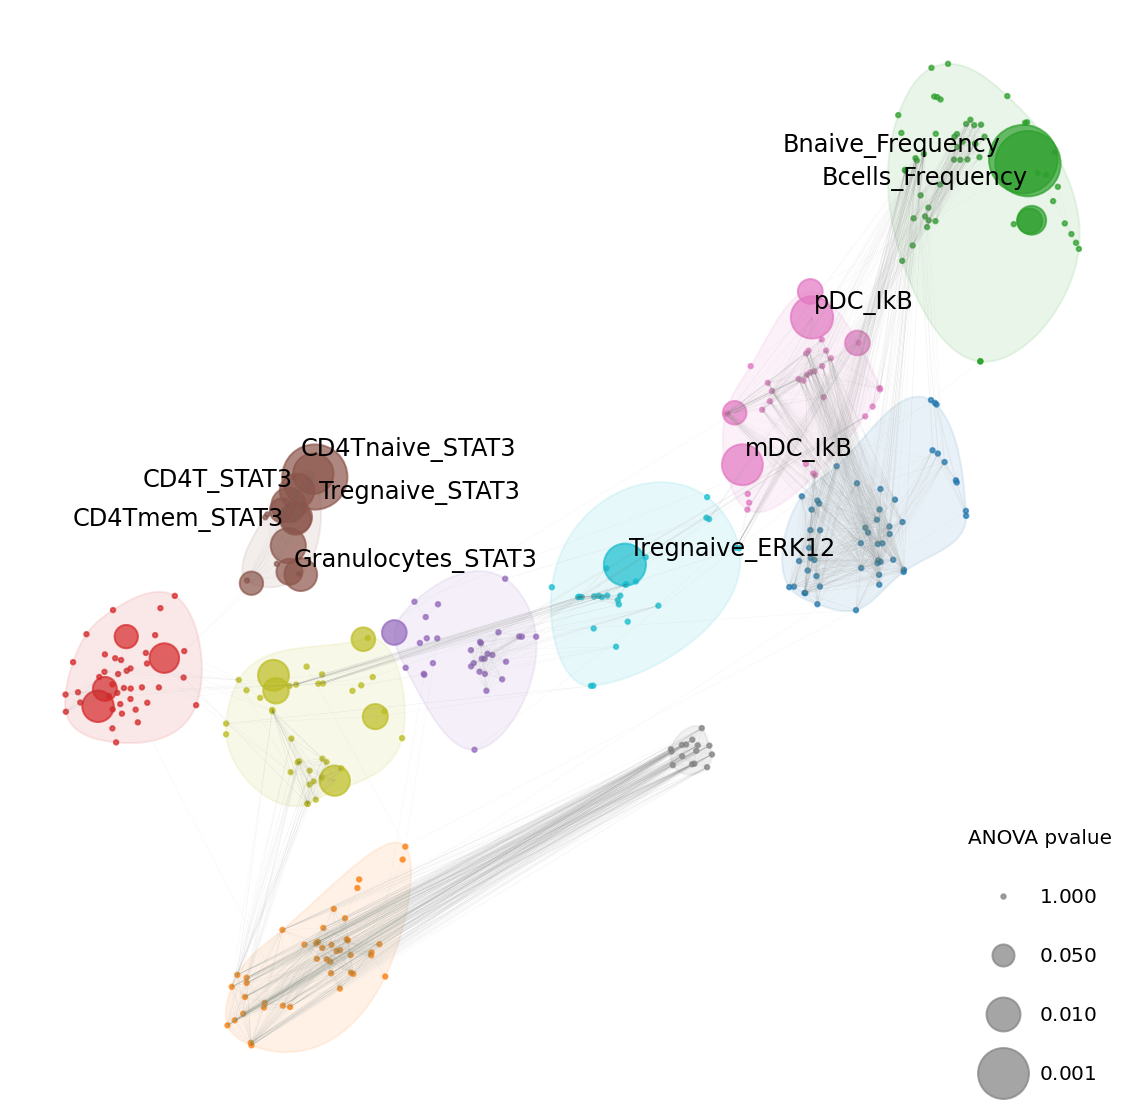

In [22]:
from adjustText import adjust_text
from matplotlib import colors

CORR_THRESH = .7
TIMESTAMP = 'D1'
# sizes_source = 'pvalue_'+TIMESTAMP
sizes_source = 'pvalue_anova'
#colors_source = 'effect_dir_'+TIMESTAMP

SIZES = []
for value in df_tsne[sizes_source].astype(float):
    if value > 0.05:
        SIZES.append(5)
    else:
        SIZES.append(2*(-np.log10(value)*6)**2)

        
COLORS = ['C'+str(i) for i in df_tsne.cluster]

fig, ax = plt.subplots(figsize=(10, 10))

# --DRAWING CLUSTERS--

for i in np.unique(cluster_labels):
    points = df_tsne[df_tsne.cluster == i][['coor1', 'coor2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    tck, _ = splprep([x_hull, y_hull], s=0, per = True)
    xx, yy = splev(np.linspace(0, 1, 100), tck, der = 0)
    
    # plot shape
    plt.fill(xx, yy, alpha=.1, color='C'+str(i), label=f'Cluster {i}')

# --DRAWING POINTS--
scatter = plt.scatter(df_tsne.coor1,
                     df_tsne.coor2, 
                     s=SIZES, 
                     marker='o', 
                     c=COLORS,
                     norm=colors.CenteredNorm(),
                     edgecolors=None,
                     cmap=cmap,
                     alpha=.7
                    )

ax.axis("off")
plt.legend()
# fig.colorbar(scatter,
#              anchor=(0, 0),
#              ax=ax, 
#              shrink=.2, 
#              label='Effect direction', 
#              aspect=8, 
#              use_gridspec=True,
#              location='right'
#             )

def funct(s):
    to_ret=np.zeros(len(s))
    for idx, el in enumerate(s):
        if el==5:
            to_ret[idx] = 1
        else:
            to_ret[idx] = np.exp(np.log(10)*(-((el/2)**(1/2))/6))
    return to_ret

kw = dict(prop="sizes", num=[1, 0.05, 0.01, 0.001], color='gray',
          func=funct)

# kw = dict(prop="sizes", num=[0, .1, .2], color='gray', fmt="{x:.2f}",
#            func=lambda s: np.sqrt(s)/75 - 0.01)

ax.legend(*scatter.legend_elements(**kw),title="ANOVA pvalue",labelspacing=2, loc='lower right', frameon=False)

for i in df_tot.columns:
    for j in df_tot.columns:
        if df_corr.loc[i,j]>=CORR_THRESH and df_corr.loc[i,j] < 1:
            sub_df = df_tsne.loc[[i, j]]
            ax.plot(sub_df.coor1, sub_df.coor2, linewidth=.2,color='gray', alpha=.05)
            
annot=[]        
for i, txt in enumerate(df_tsne.index):
    if df_tsne.iloc[i][sizes_source] <= 0.01:
        annot.append(ax.annotate(txt, (df_tsne.iloc[i].coor1, df_tsne.iloc[i].coor2), fontsize=12))
        
adjust_text(annot)

#plt.savefig('./Correlation networks/Correlation network - ANOVA/correlation networks.pdf', dpi=200)

# Trajectories

In [23]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [24]:
from scipy.interpolate import make_interp_spline 
import matplotlib

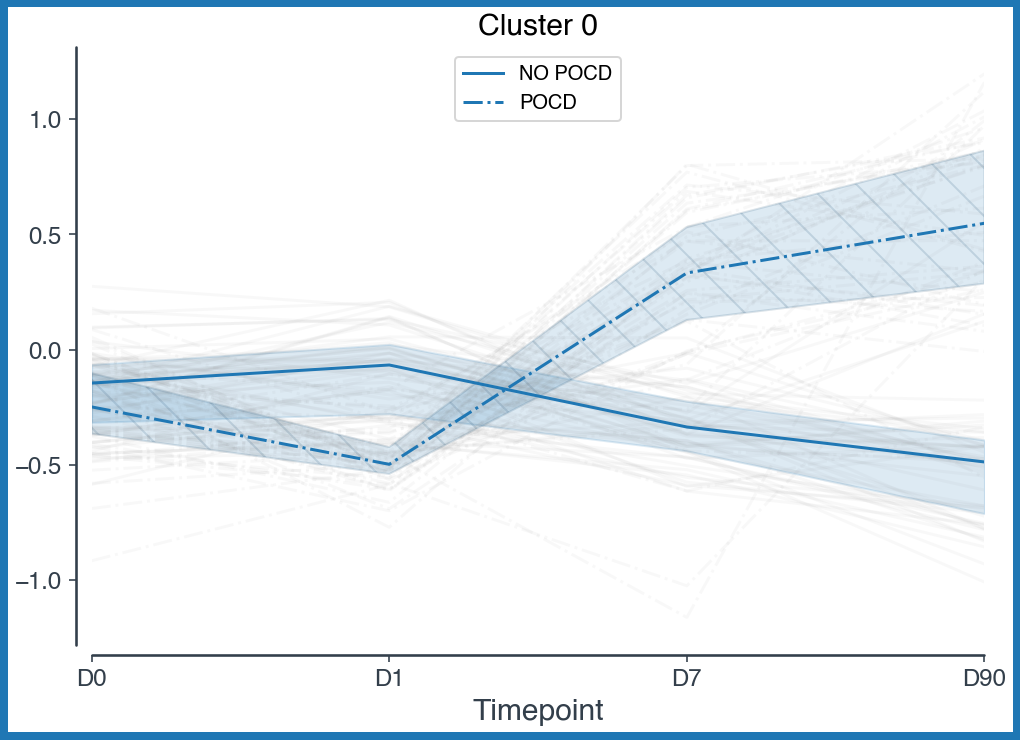

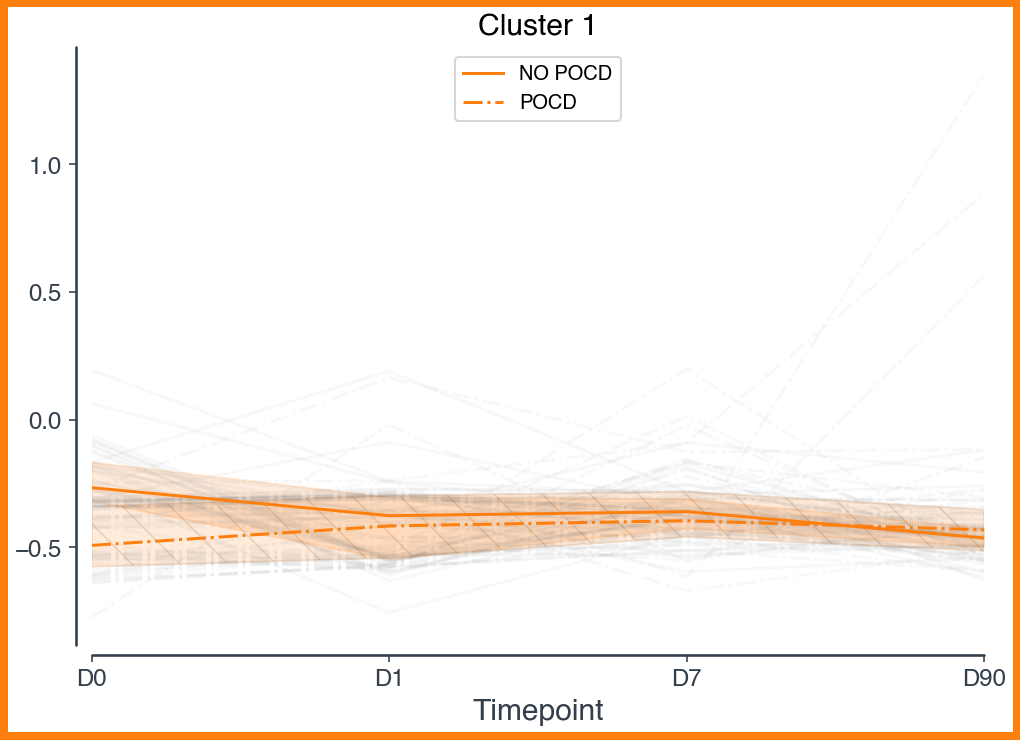

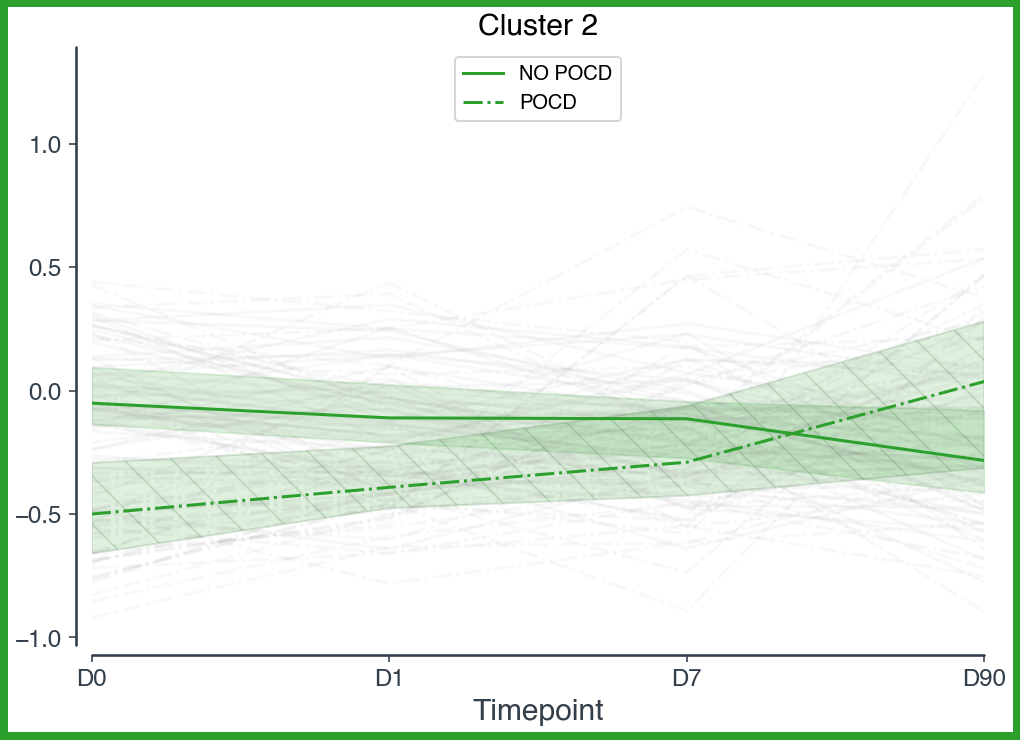

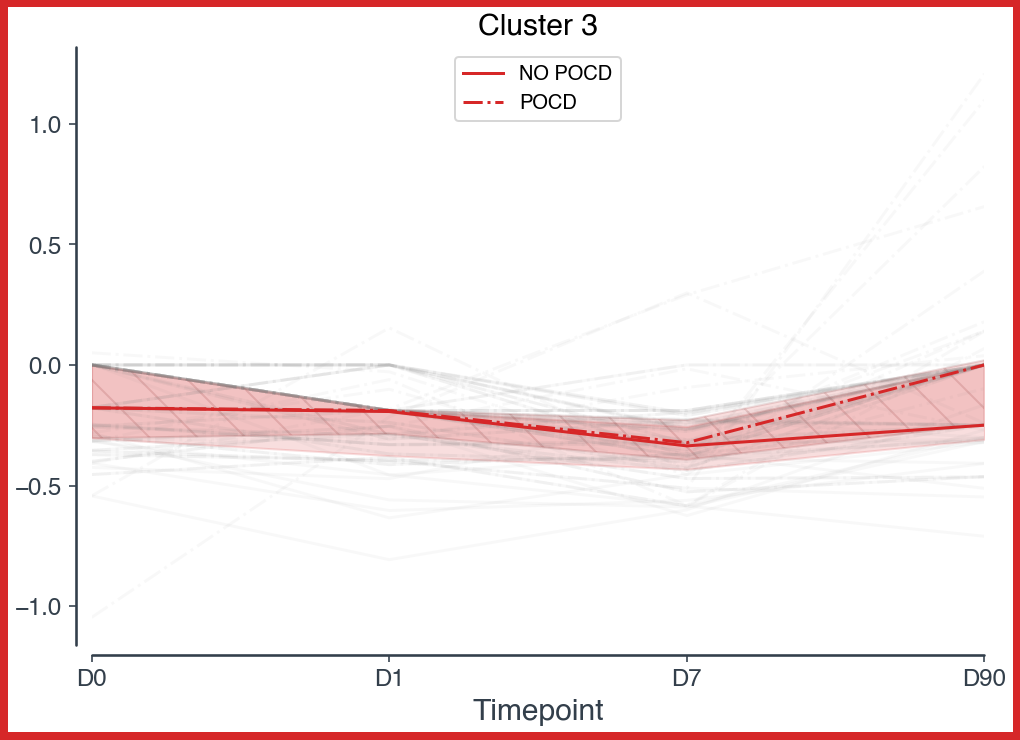

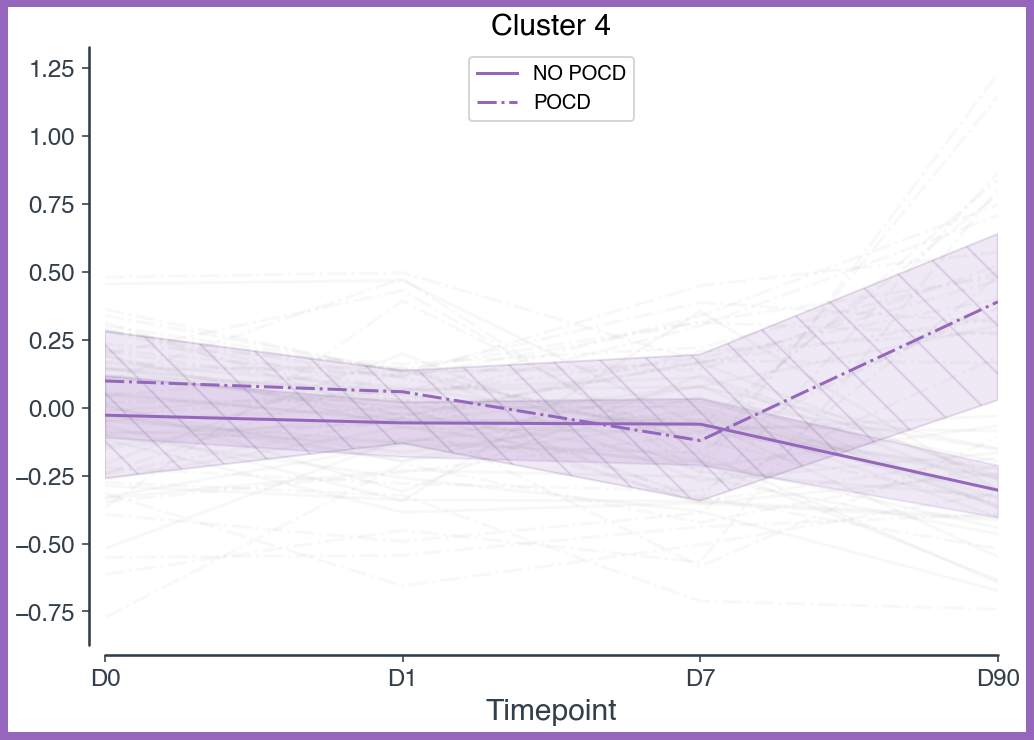

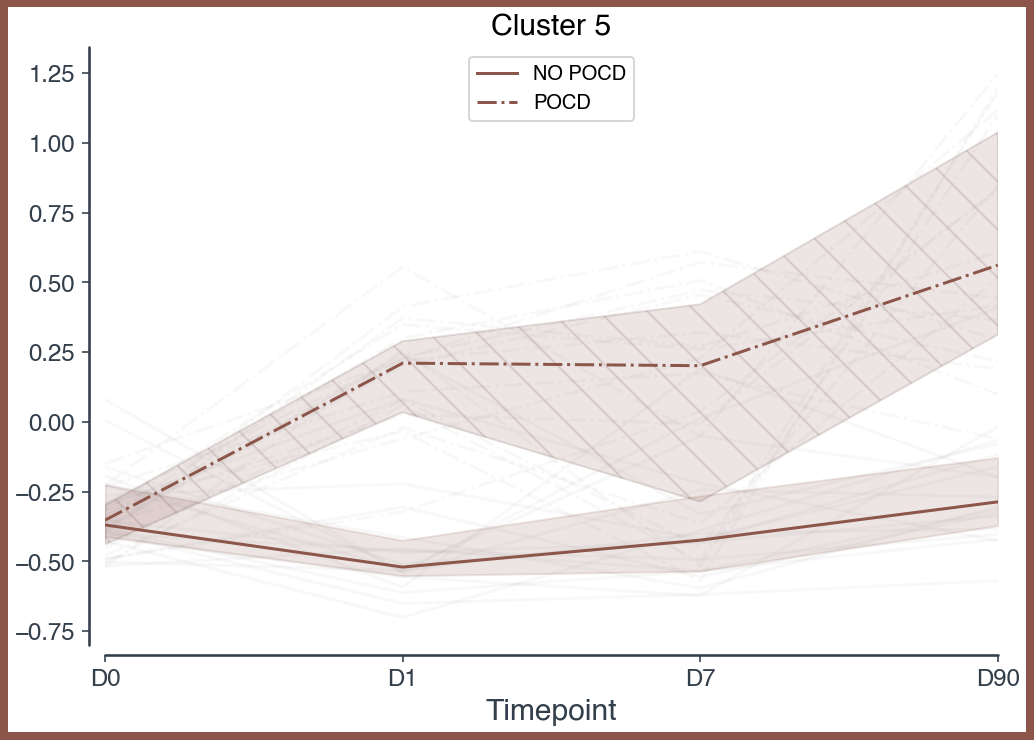

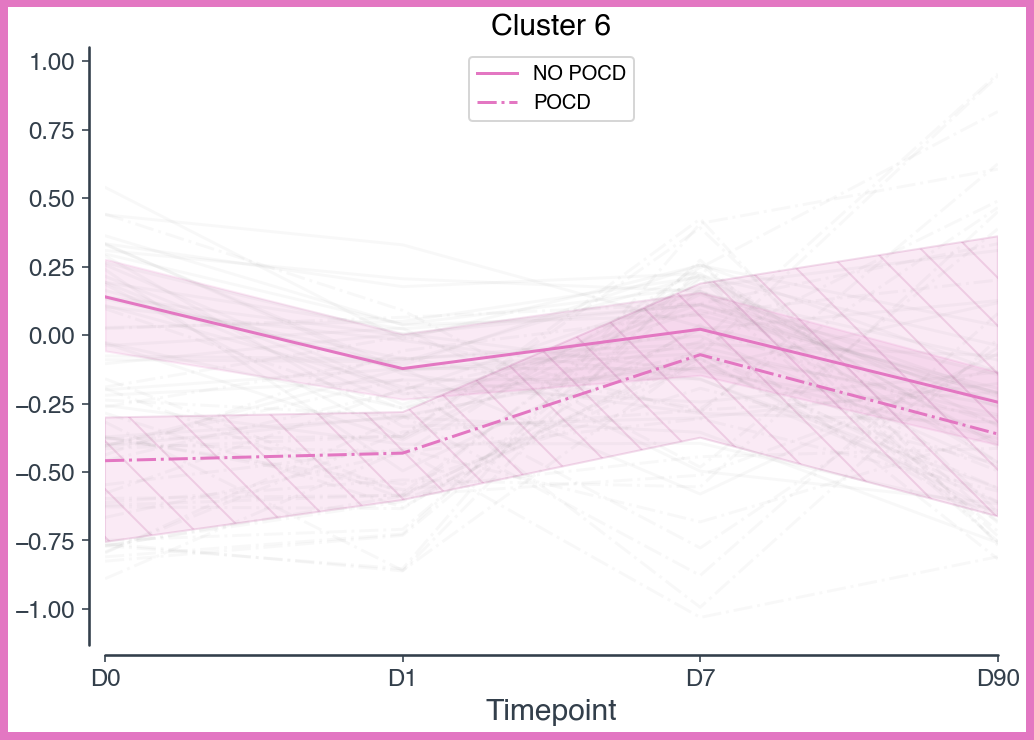

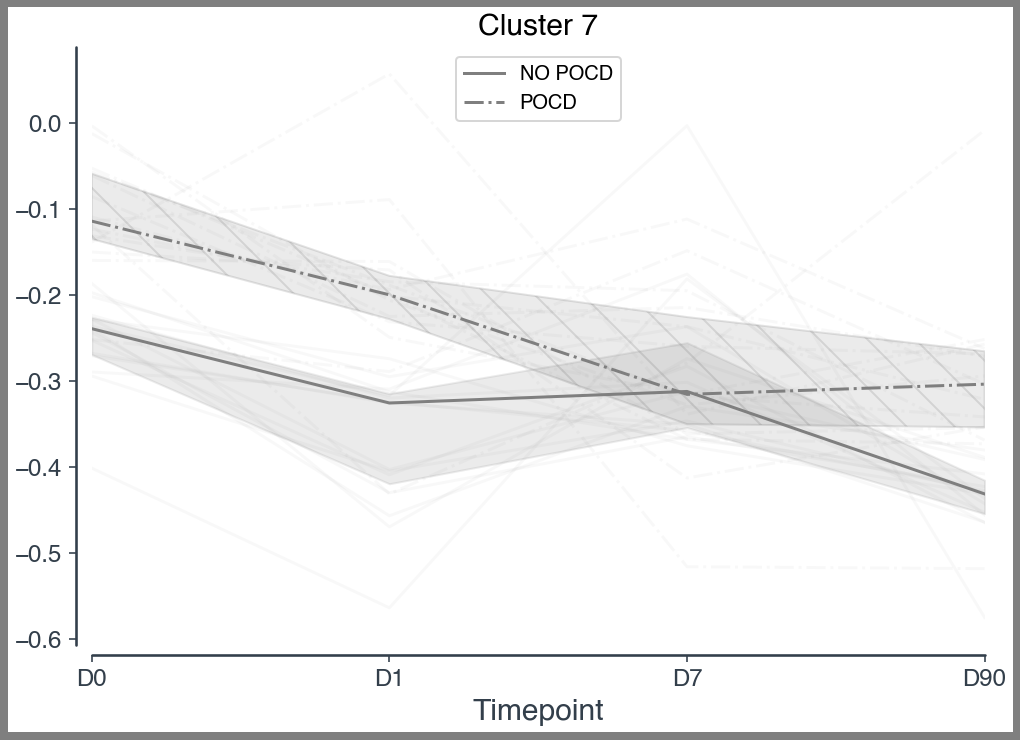

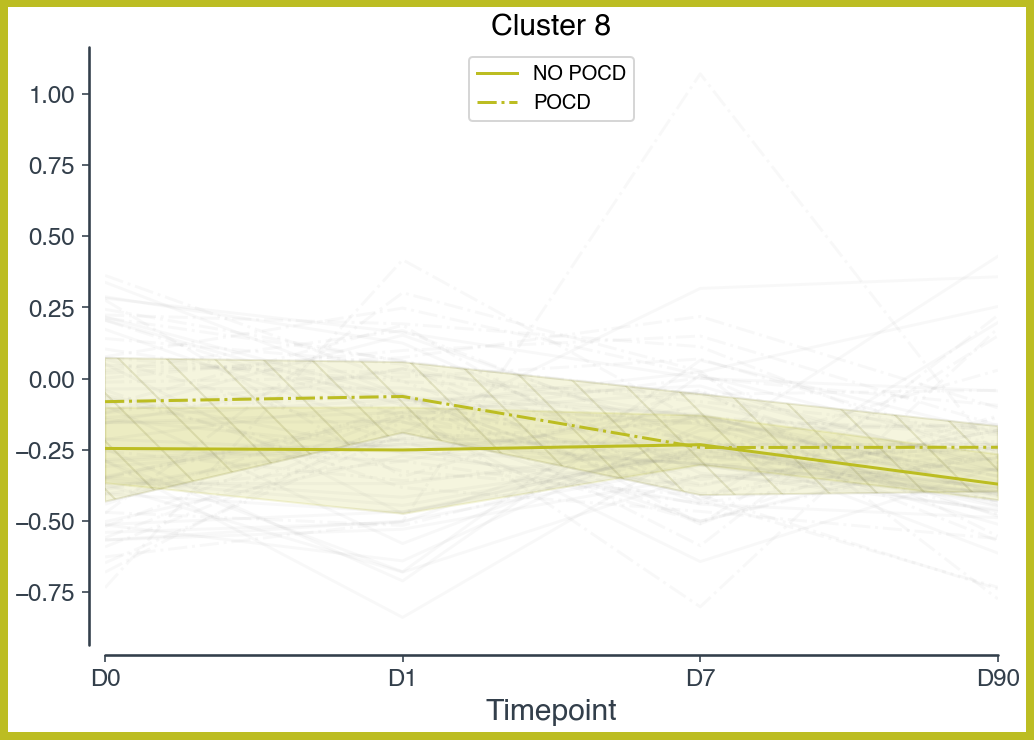

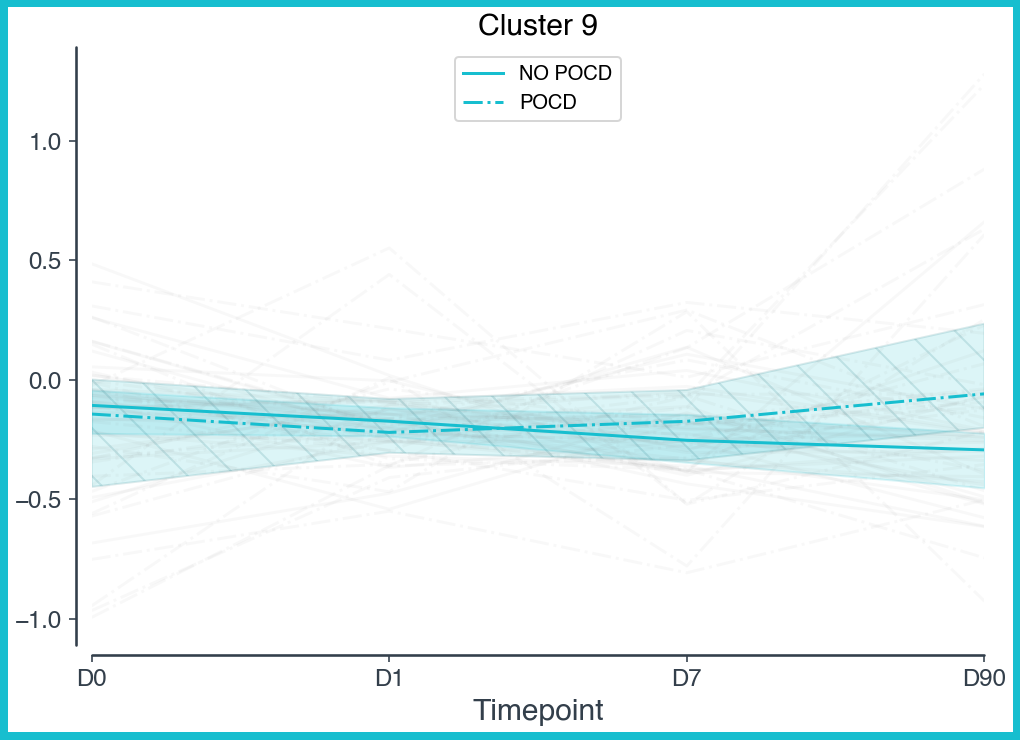

In [45]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

for i in np.unique(cluster_labels):

    fig,ax = plt.subplots(1, 1, figsize=(8,5.5), edgecolor='C'+str(i), linewidth=8)
    

    cluster_features = df_tsne[df_tsne.cluster==i].index
    control_medians = []
    pocd_medians = []

    for feature in cluster_features:
        control_feature_medians = []
        pocd_feature_medians = []
        for df, labels in [(D0_std, labels_D0),
                           (D1_std, labels_D1),
                           (D7_std, labels_D7),
                           (D90_std, labels_D90)]:
            
            control_feature_medians.append(df[labels.POCD_J7_pos==0][feature].median())
            pocd_feature_medians.append(df[labels.POCD_J7_pos==1][feature].median())
            
        control_medians.append(control_feature_medians)
        pocd_medians.append(pocd_feature_medians)
    
        ax.plot(['D0', 'D1', 'D7', 'D90'], control_feature_medians,alpha=.05, color='gray')
        ax.plot(['D0', 'D1', 'D7', 'D90'], pocd_feature_medians,alpha=.05,linestyle='-.',color='gray')
    
    q3_control, q1_control = np.percentile(control_medians, [75, 25],axis=0)
    q3_pocd, q1_pocd = np.percentile(pocd_medians, [75, 25],axis=0)
    
    ax.plot(['D0', 'D1', 'D7', 'D90'], np.median(control_medians,axis=0), color='C'+str(i), label='NO POCD')
    ax.fill_between(['D0', 'D1', 'D7', 'D90'], q3_control, q1_control, color='C'+str(i),alpha=.15,linestyle='-') 
    
    ax.plot(['D0', 'D1', 'D7', 'D90'], np.median(pocd_medians,axis=0), color='C'+str(i), linestyle='-.',  label='POCD')
    test = ax.fill_between(['D0', 'D1', 'D7', 'D90'], q3_pocd, q1_pocd, color='C'+str(i), alpha=.15)
    
    col = matplotlib.colors.to_rgb('C'+str(i))
    ax.set_title(f'Cluster {i}', fontsize=15)
    
    test.set_hatch('\\')
    col = adjust_lightness('C'+str(i),.6)
    test.set_edgecolor(col)
    
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[['left',"bottom"]].set_capstyle("round")
    ax.spines[['left',"bottom"]].set_linewidth(1.3)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Timepoint', fontsize=15, fontweight='black', color = '#333F4B')
    # add some space between the axis and the plot
    ax.set_xlim(0, 3)
    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.legend(loc='upper center')
    
    
    #fig.savefig(f'./Correlation network - ANOVA/Clusters Trajectories/Medians & all features/Trajectories Cluster {i}.pdf', dpi=250,edgecolor=fig.get_edgecolor())

Plotting with interpolation

/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/3856129455.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/3856129455.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/3856129455.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/3856129455.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/3856129455.py:77: UserWarning: FixedFormatter should only be used together w

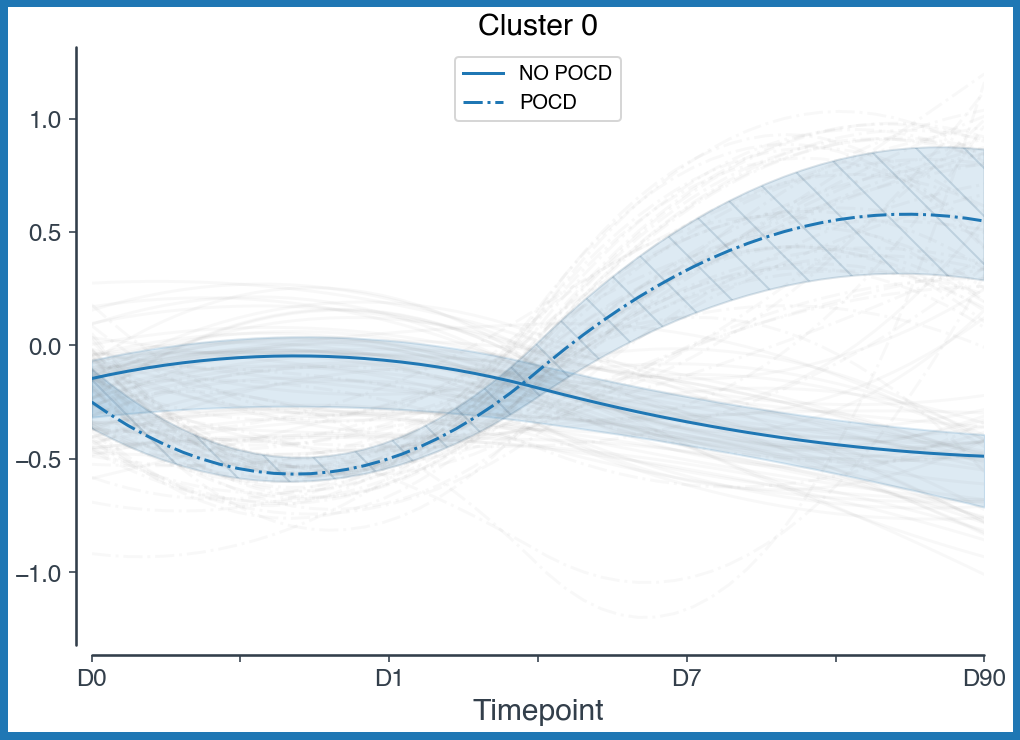

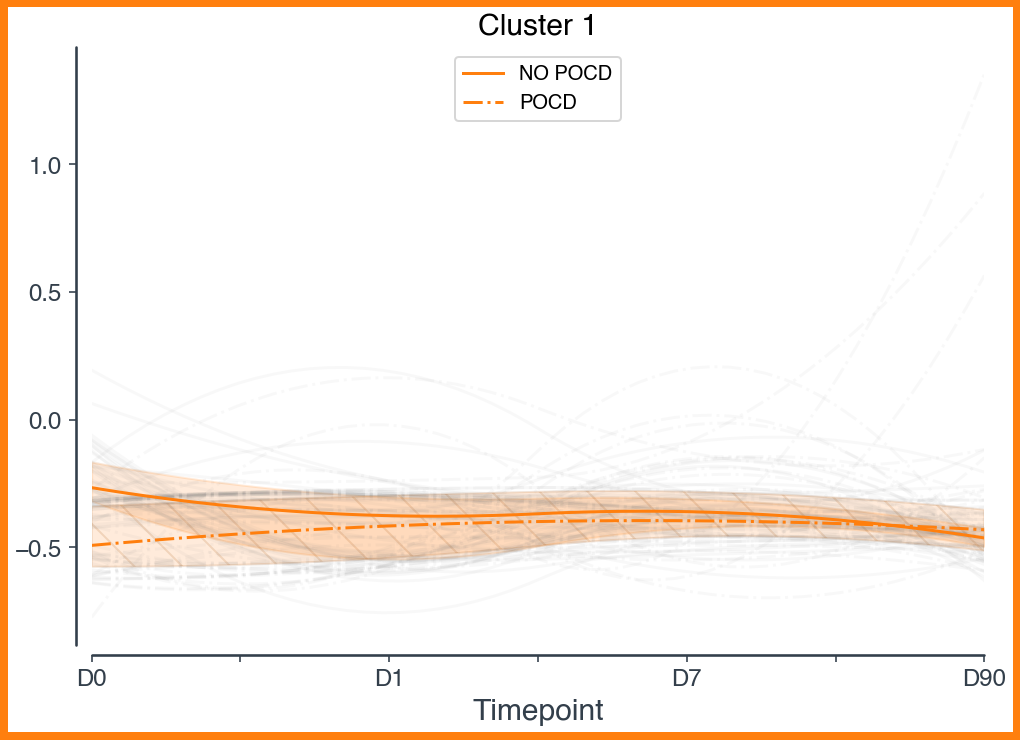

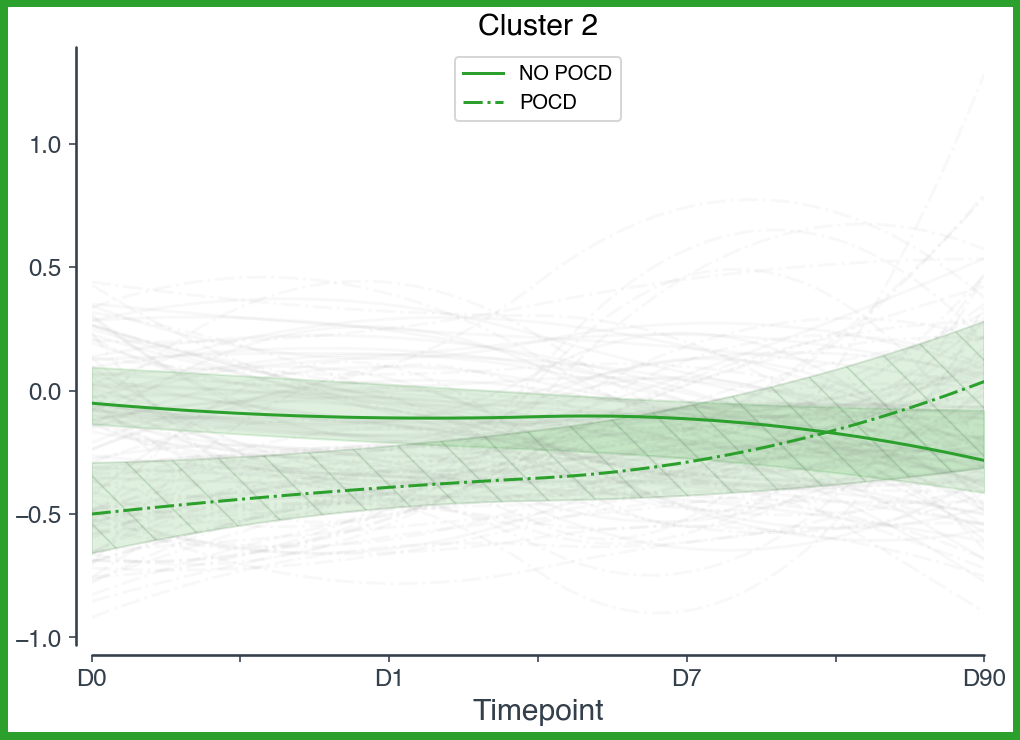

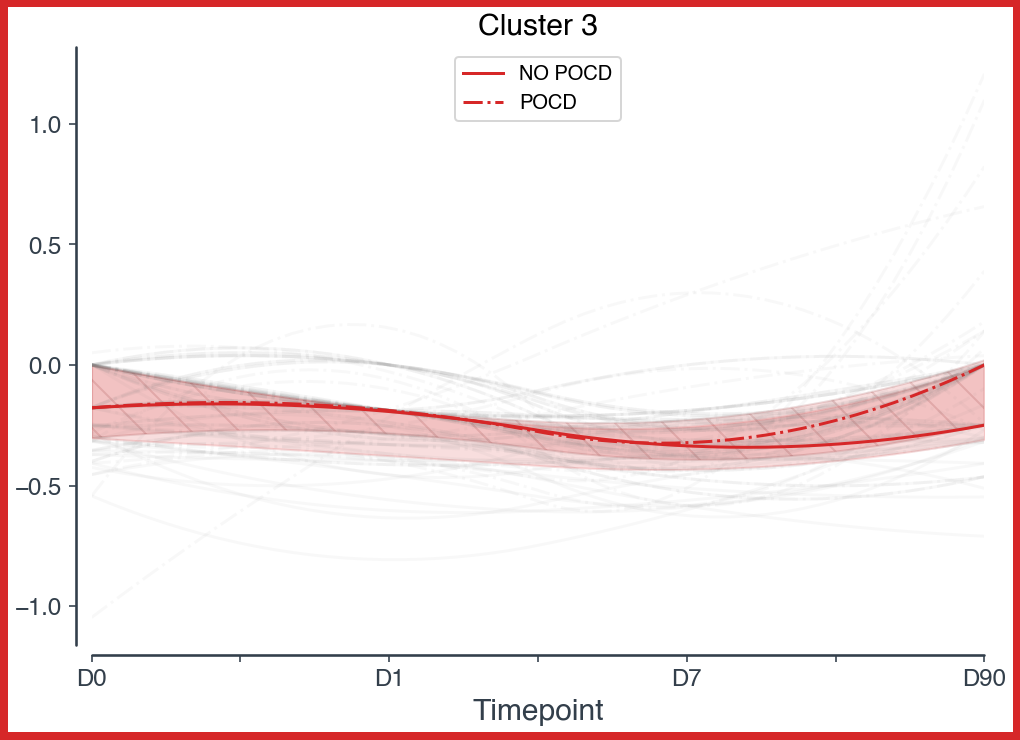

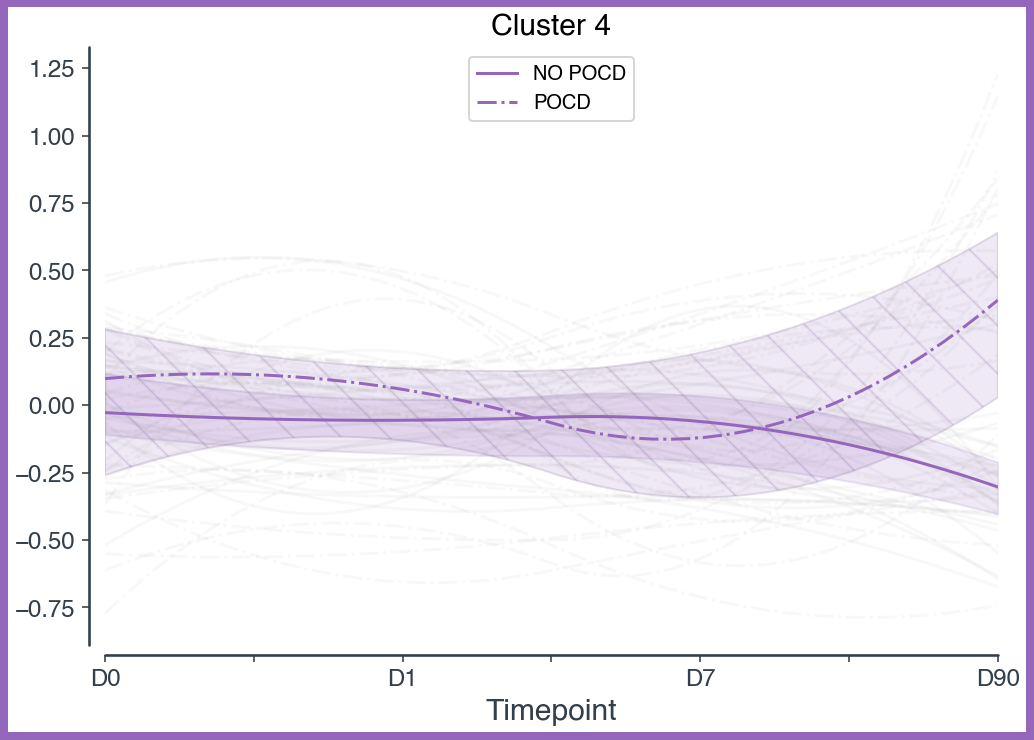

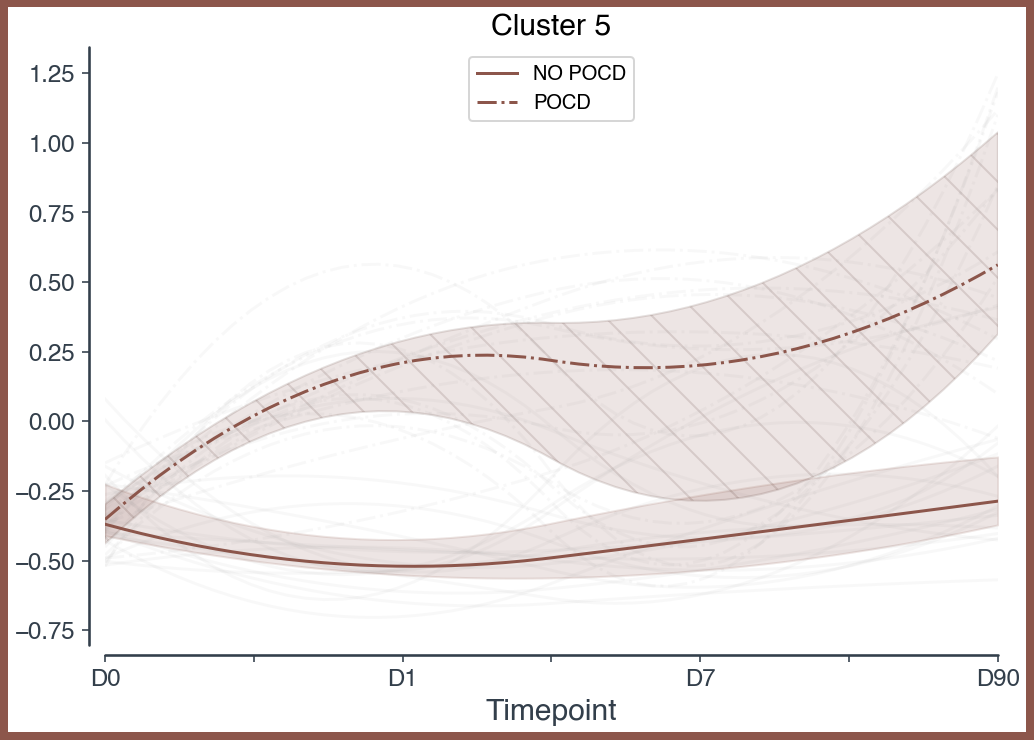

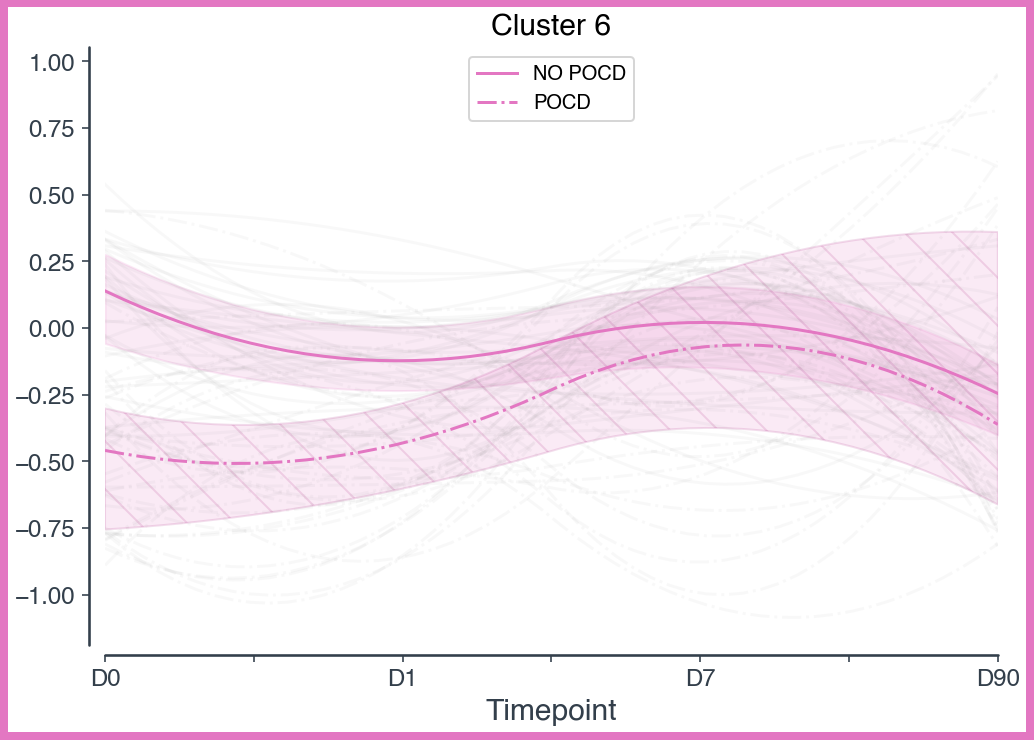

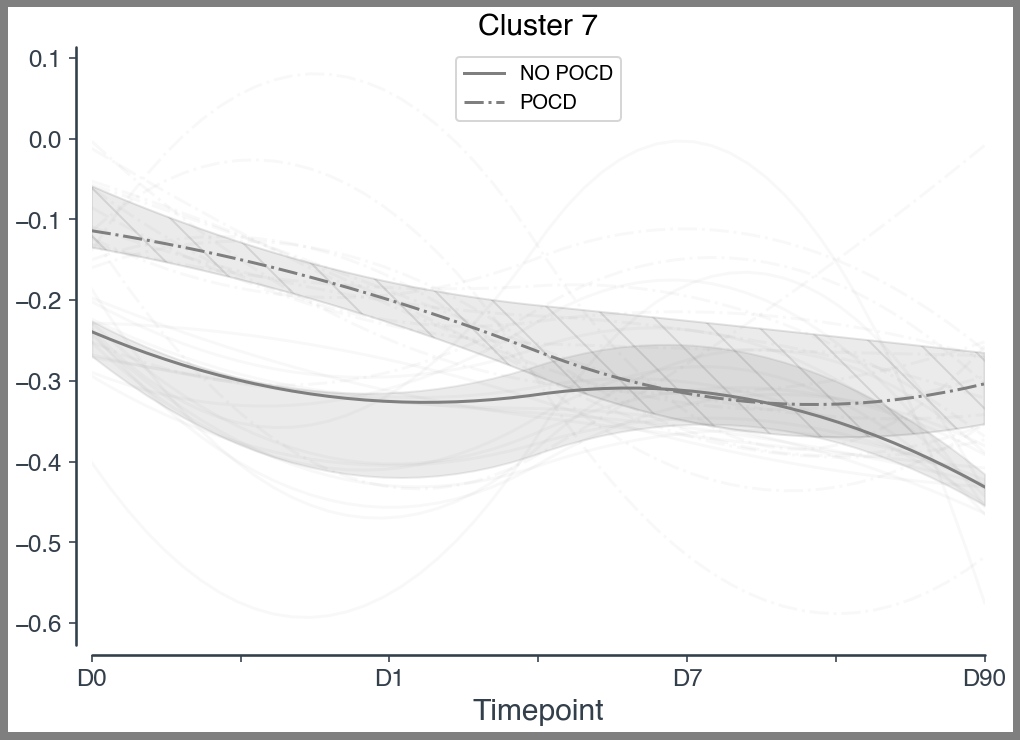

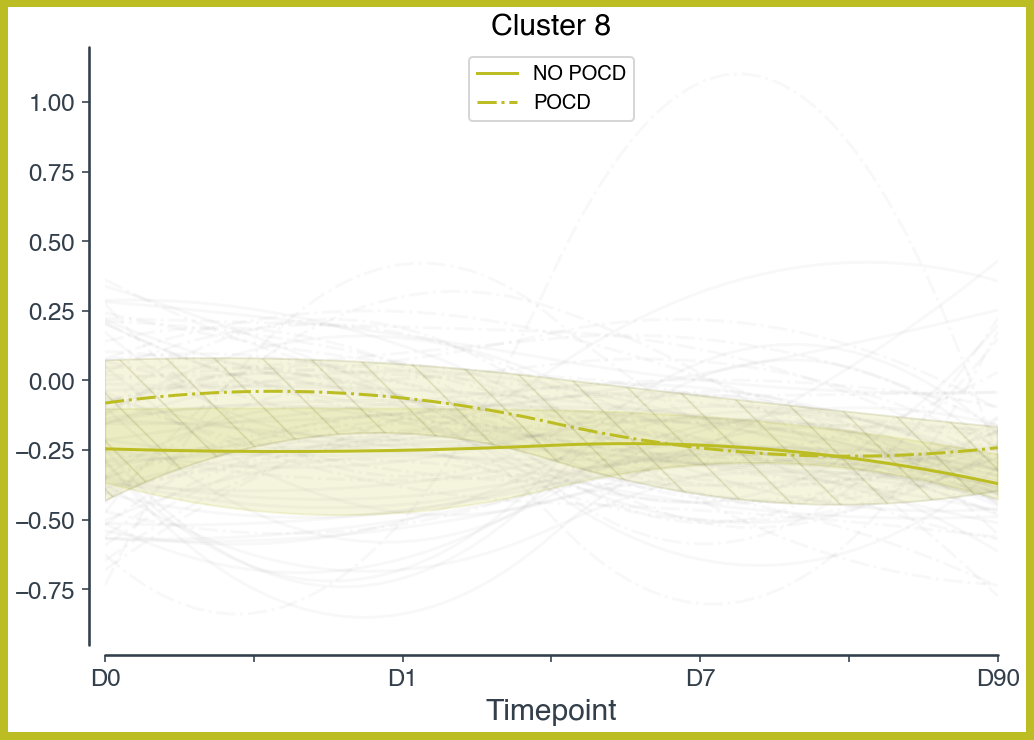

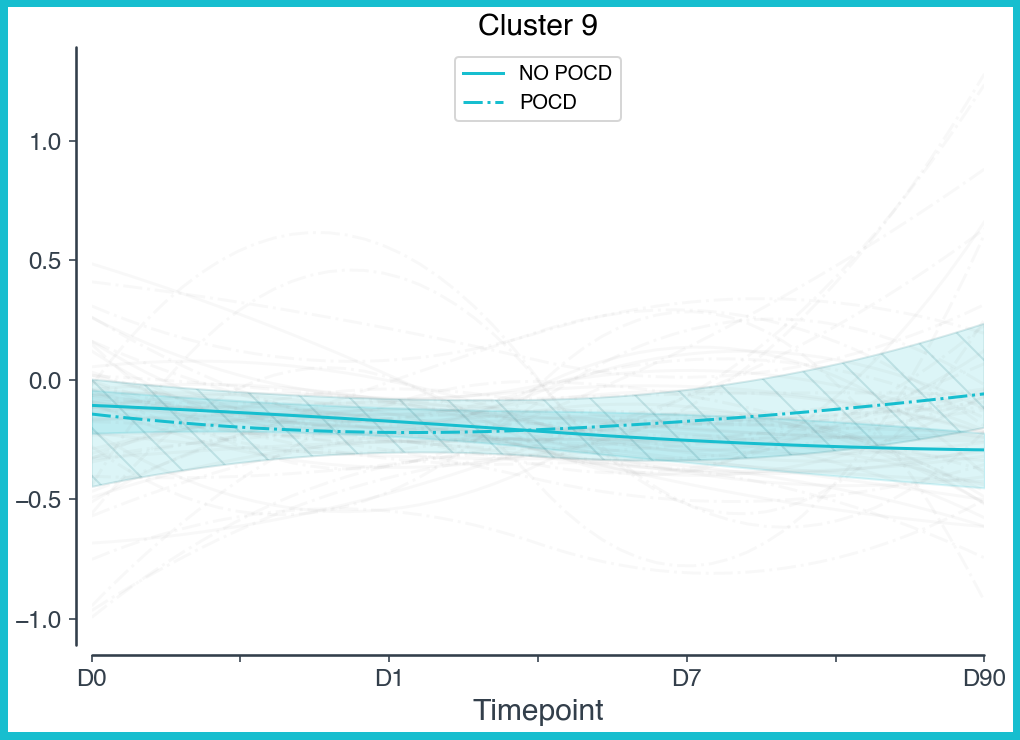

In [46]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

for i in np.unique(cluster_labels):
    fig,ax = plt.subplots(1, 1, figsize=(8,5.5), edgecolor='C'+str(i), linewidth=8)
    cluster_features = df_tsne[df_tsne.cluster==i].index
    control_medians = []
    pocd_medians = []

    for feature in cluster_features:
        control_feature_medians = []
        pocd_feature_medians = []
        for df, labels in [(D0_std, labels_D0),
                           (D1_std, labels_D1),
                           (D7_std, labels_D7),
                           (D90_std, labels_D90)]:
            
            control_feature_medians.append(df[labels.POCD_J7_pos==0][feature].median())
            pocd_feature_medians.append(df[labels.POCD_J7_pos==1][feature].median())
            
        x_new = np.linspace(0, 3, 50)
            
        control_med_feature_BSpline = make_interp_spline([0, 1, 2, 3],control_feature_medians, k=2)
        pocd_med_feature_BSpline = make_interp_spline([0, 1, 2, 3], pocd_feature_medians, k=2)

        y_control_feature = control_med_feature_BSpline(x_new)
        y_pocd_feature = pocd_med_feature_BSpline(x_new)

        ax.plot(x_new, y_control_feature,alpha=.05, color='gray')
        ax.plot(x_new, y_pocd_feature,alpha=.05,linestyle='-.',color='gray')    
            
        control_medians.append(control_feature_medians)
        pocd_medians.append(pocd_feature_medians)
    

    q3_control, q1_control = np.percentile(control_medians, [75 ,25],axis=0)
    q3_pocd, q1_pocd = np.percentile(pocd_medians, [75 ,25],axis=0)
    
    x_new = np.linspace(0, 3, 50)
    
    control_med_BSpline = make_interp_spline([0, 1, 2, 3],np.median(control_medians,axis=0), k=2)
    control_q3_BSpline = make_interp_spline([0, 1, 2, 3], q3_control, k=2)
    control_q1_BSpline = make_interp_spline([0, 1, 2, 3], q1_control, k=2)
    y_control_med = control_med_BSpline(x_new)
    y_control_q3 = control_q3_BSpline(x_new)
    y_control_q1 = control_q1_BSpline(x_new)
    
    ax.plot(x_new, y_control_med, color='C'+str(i), label='NO POCD')
    ax.fill_between(x_new, y_control_q3, y_control_q1, color='C'+str(i),alpha=.15,linestyle='-') 
    
    pocd_med_BSpline = make_interp_spline([0, 1, 2, 3], np.median(pocd_medians,axis=0), k=2)
    pocd_q3_BSpline = make_interp_spline([0, 1, 2, 3], q3_pocd, k=2)
    pocd_q1_BSpline = make_interp_spline([0, 1, 2, 3], q1_pocd, k=2)
    y_pocd_med = pocd_med_BSpline(x_new)
    y_pocd_q3 = pocd_q3_BSpline(x_new)
    y_pocd_q1 = pocd_q1_BSpline(x_new)
   
    ax.plot(x_new, y_pocd_med, color='C'+str(i), linestyle='-.',  label='POCD')
    test = ax.fill_between(x_new, y_pocd_q3, y_pocd_q1, color='C'+str(i), alpha=.15)
    
    col = matplotlib.colors.to_rgb('C'+str(i))
    ax.set_title(f'Cluster {i}', fontsize=15)
    
    test.set_hatch('\\')
    col = adjust_lightness('C'+str(i),.6)
    test.set_edgecolor(col)
    
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[['left',"bottom"]].set_capstyle("round")
    ax.spines[['left',"bottom"]].set_linewidth(1.3)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
    ax.set_xlabel('Timepoint', fontsize=15, fontweight='black', color = '#333F4B')
    # add some space between the axis and the plot
    ax.set_xlim(0, 3)
    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.legend(loc='upper center')
    
    #fig.savefig(f'./Correlation network - ANOVA/Clusters Trajectories/Medians & all features/Trajectories Cluster {i} Interp.pdf', dpi=250,edgecolor=fig.get_edgecolor())

# Top Feature Trajectories

CD56brightCD16negNK_CREB
Bnaive_p38
Bnaive_Frequency
pDC_STAT1
Bmem_IkB
Tregnaive_STAT3
pDC_IkB
Th2_STAT6
CD56brightCD16negNK_ERK12
Tregnaive_ERK12


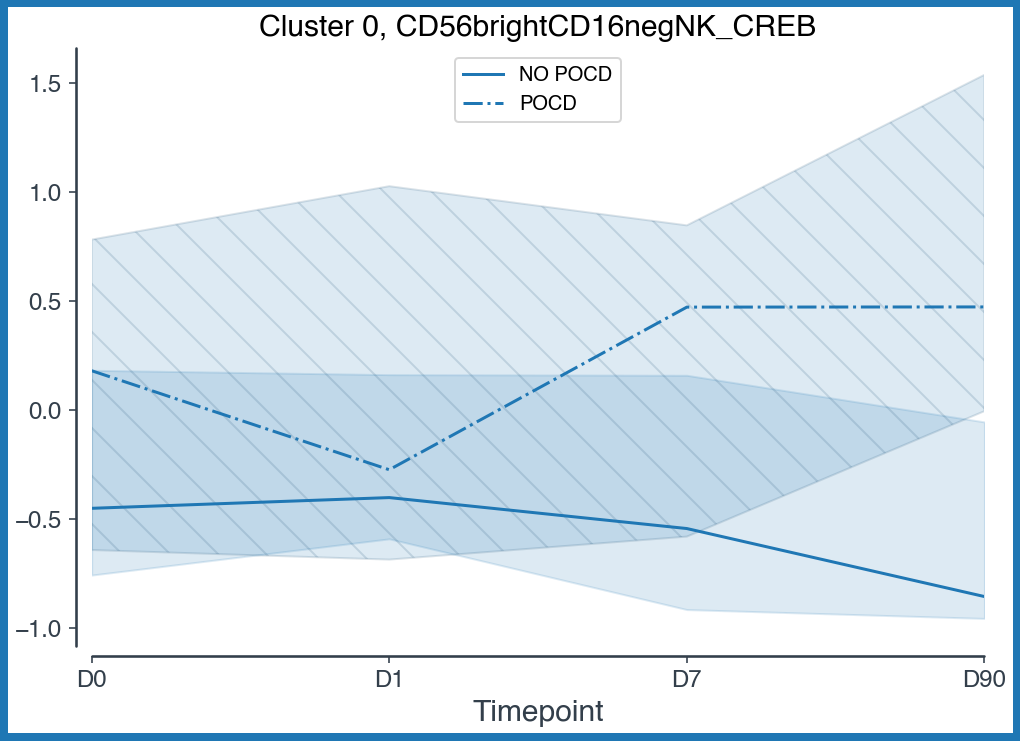

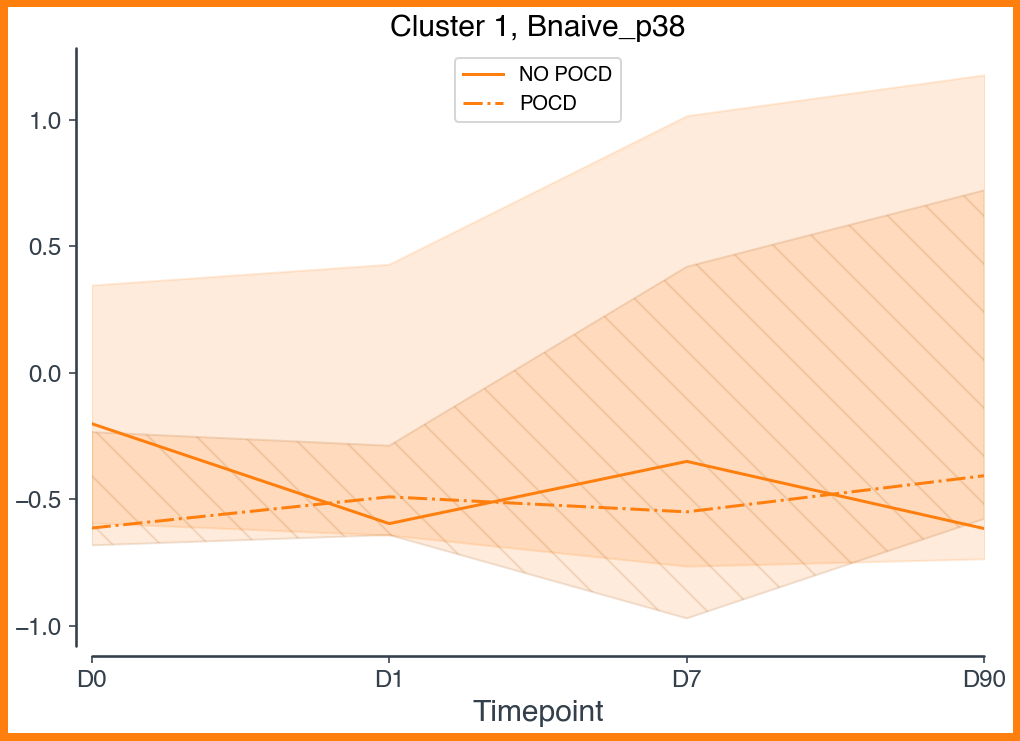

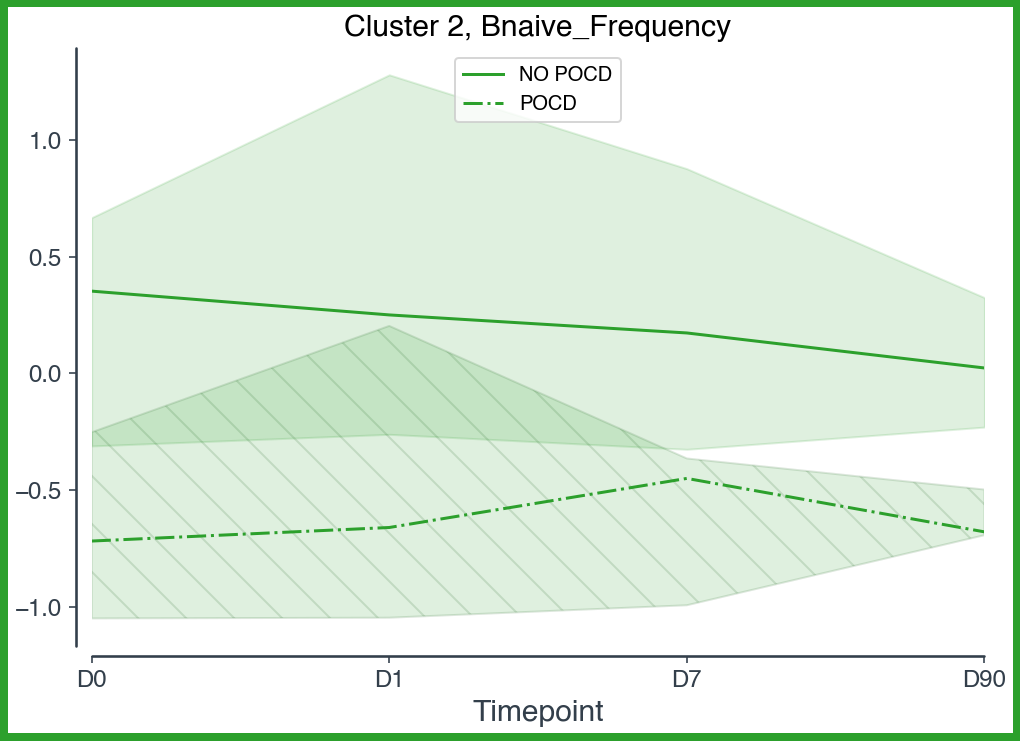

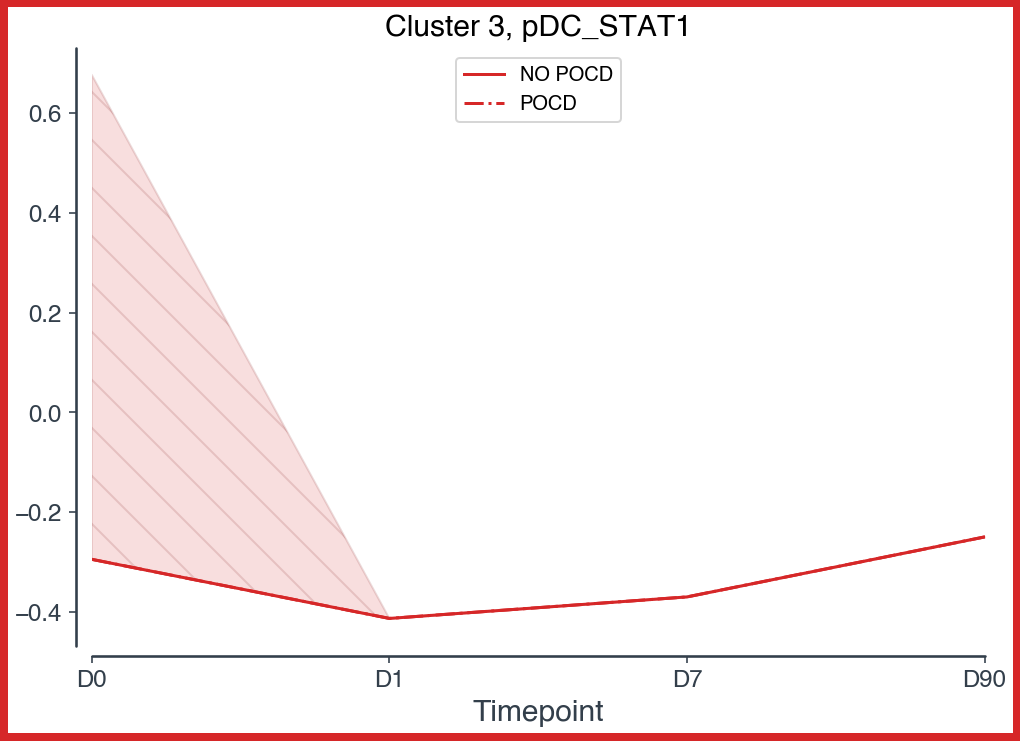

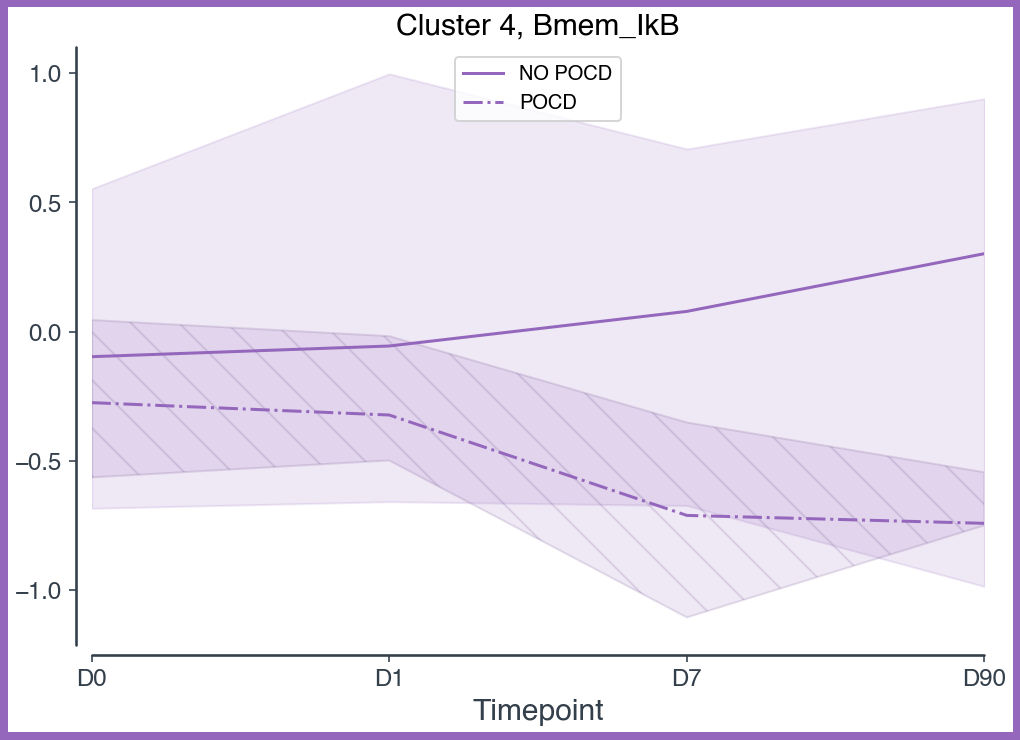

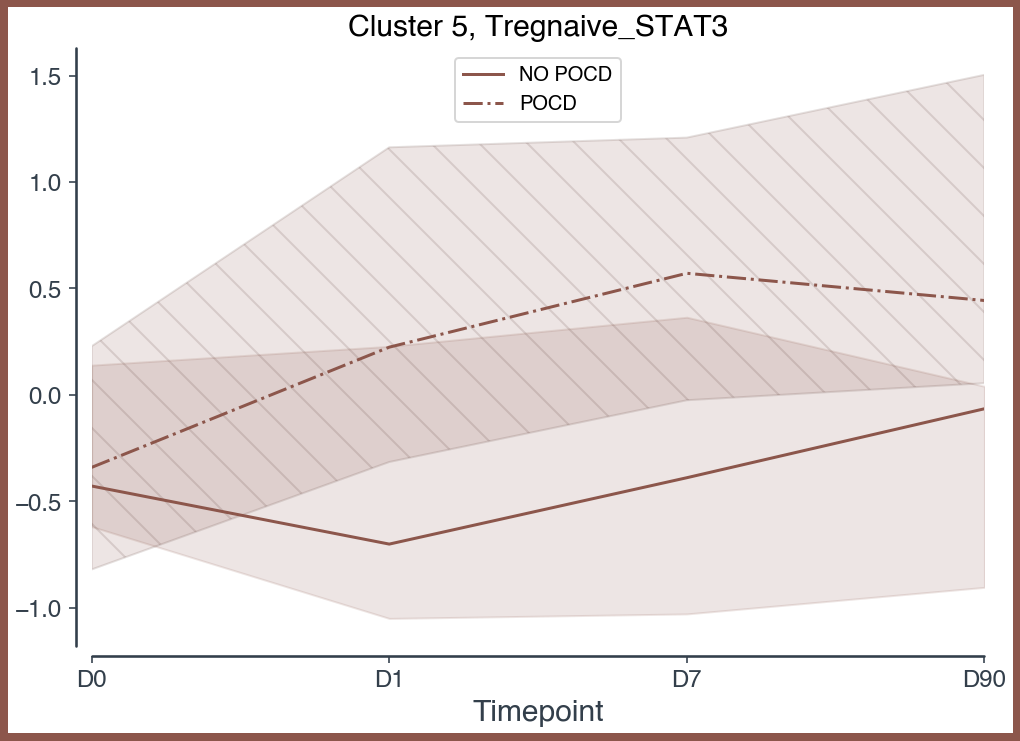

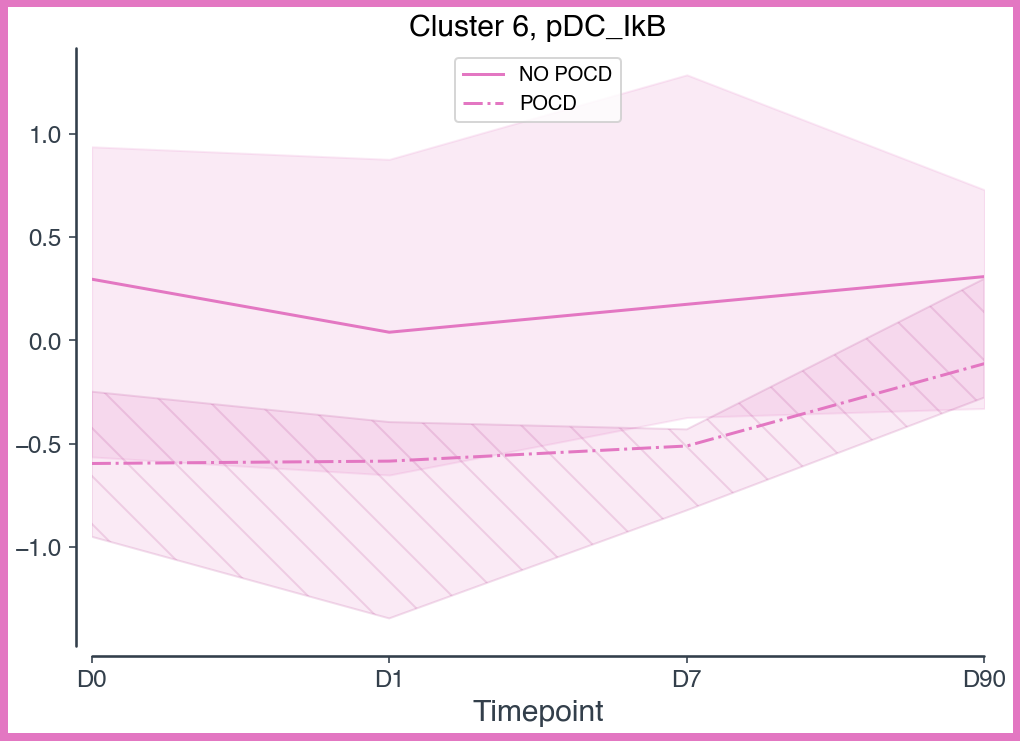

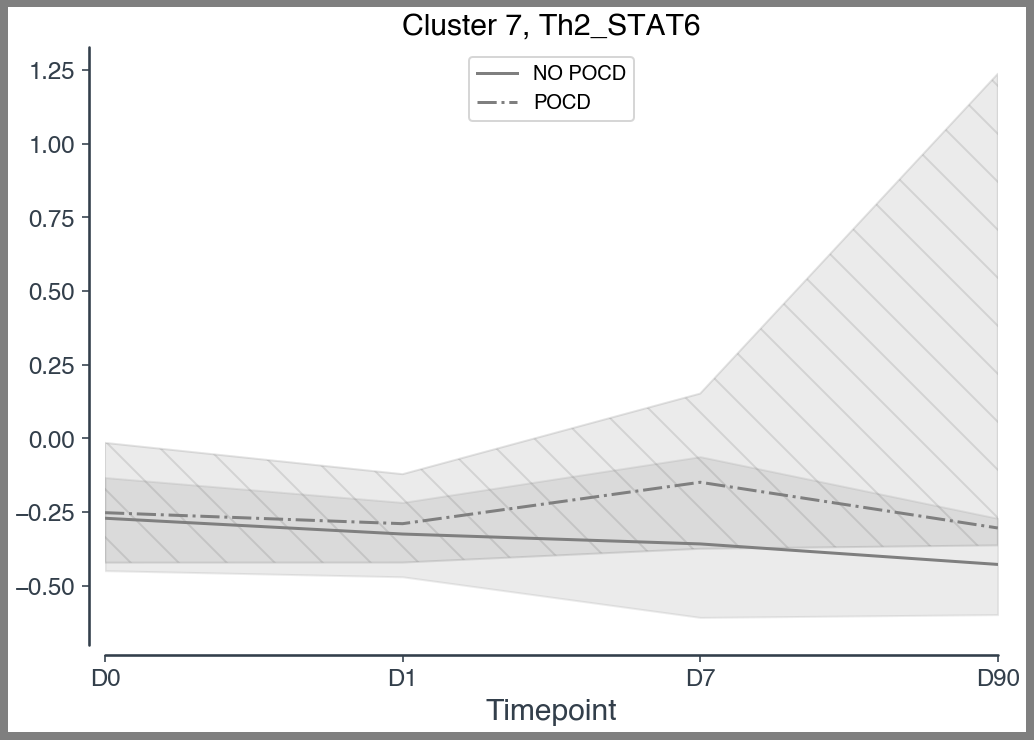

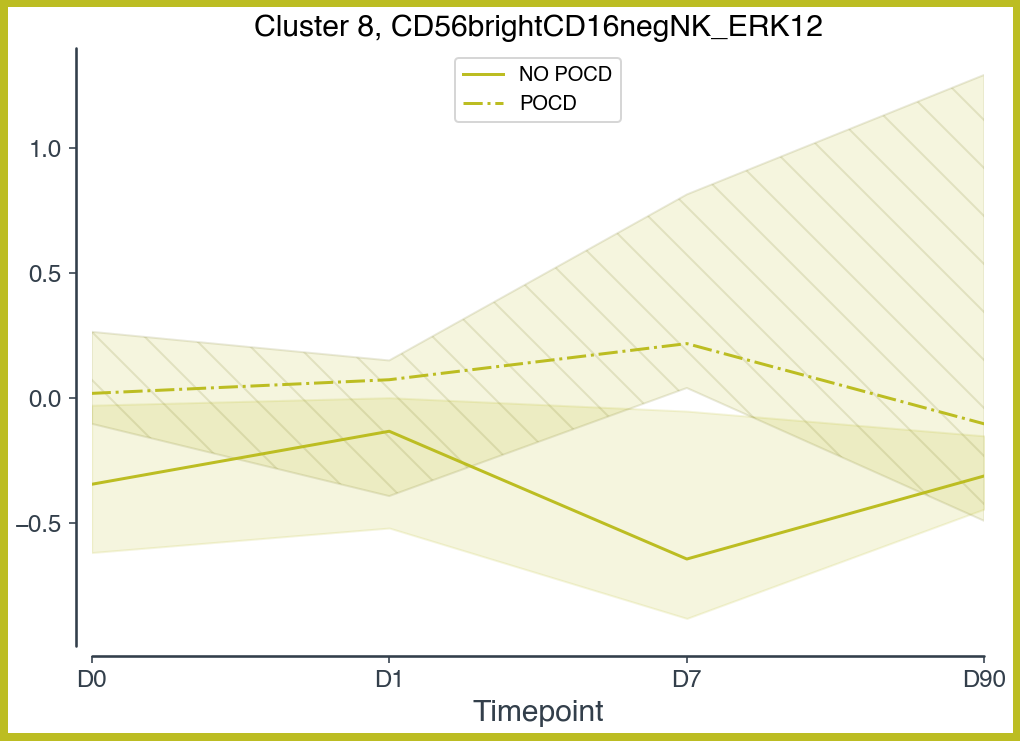

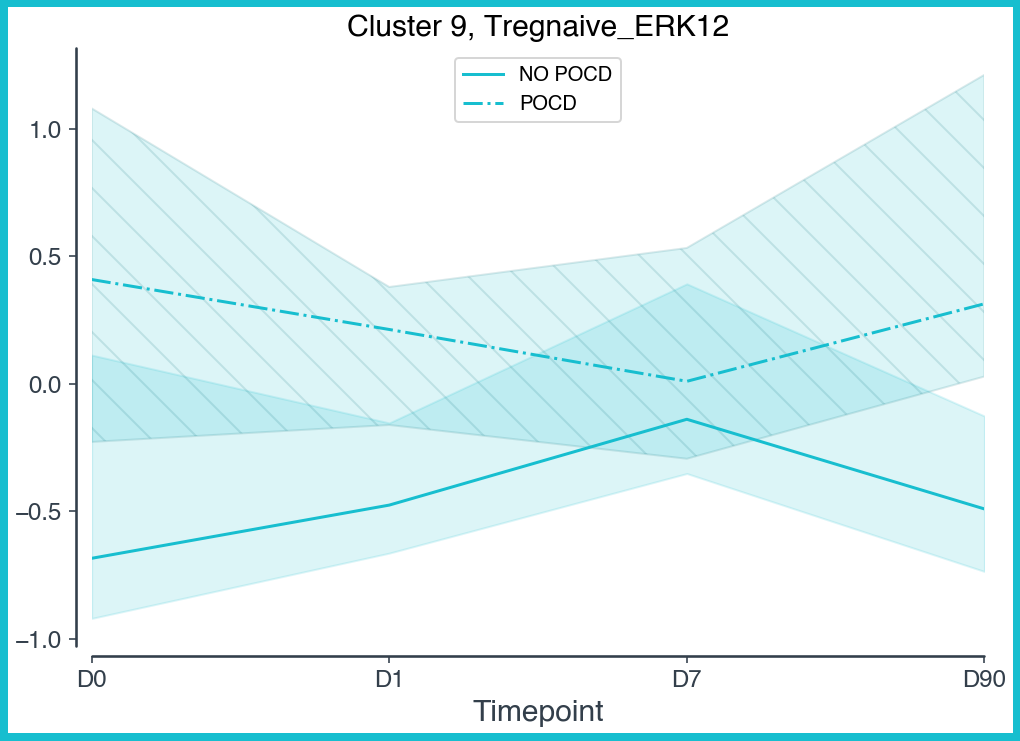

In [125]:
for i in np.unique(cluster_labels):

    fig,ax = plt.subplots(1, 1, figsize=(8,5.5), edgecolor='C'+str(i), linewidth=8)
    top_feature = df_tsne[df_tsne.cluster==i].pvalue_anova.idxmin()
    print(top_feature)
    control_medians = []
    control_q3, control_q1 = [], []
    
    pocd_medians = []
    pocd_q3, pocd_q1 = [], []
    
    for df, labels in [(D0_std, labels_D0),
                       (D1_std, labels_D1),
                       (D7_std, labels_D7),
                       (D90_std, labels_D90)]:
        
        control_values = df[labels.POCD_J7_pos==0][top_feature]
        control_medians.append(control_values.median())
        tmp_control_q3, tmp_control_q1 = np.nanpercentile(control_values, [75, 25])
        control_q1.append(tmp_control_q1)
        control_q3.append(tmp_control_q3)
        
        pocd_values = df[labels.POCD_J7_pos==1][top_feature]
        pocd_medians.append(pocd_values.median())
        tmp_pocd_q3, tmp_pocd_q1 = np.nanpercentile(pocd_values, [75, 25])
        pocd_q1.append(tmp_pocd_q1)
        pocd_q3.append(tmp_pocd_q3)
    
#         ax.plot(['D0', 'D1', 'D7', 'D90'], control_feature_medians,alpha=.05, color='gray')
#         ax.plot(['D0', 'D1', 'D7', 'D90'], pocd_feature_medians,alpha=.05,linestyle='-.',color='gray')
    
    ax.plot(['D0', 'D1', 'D7', 'D90'], control_medians, color='C'+str(i), label='NO POCD')
    ax.fill_between(['D0', 'D1', 'D7', 'D90'], control_q3, control_q1, color='C'+str(i), alpha=.15, linestyle='-')
    
    ax.plot(['D0', 'D1', 'D7', 'D90'], pocd_medians, color='C'+str(i), linestyle='-.', label='POCD')
    test =  ax.fill_between(['D0', 'D1', 'D7', 'D90'], pocd_q3, pocd_q1, color='C'+str(i), alpha=.15)
    
    col = matplotlib.colors.to_rgb('C'+str(i))
    ax.set_title(f'Cluster {i}, {top_feature}', fontsize=15)
    
    test.set_hatch('\\')
    col = adjust_lightness('C'+str(i),.6)
    test.set_edgecolor(col)
    
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[['left',"bottom"]].set_capstyle("round")
    ax.spines[['left',"bottom"]].set_linewidth(1.3)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Timepoint', fontsize=15, fontweight='black', color = '#333F4B')
    # add some space between the axis and the plot
    ax.set_xlim(0, 3)
    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.legend(loc='upper center')
    
    
    fig.savefig(f'./Correlation network - ANOVA/Top features Trajectories/Medians only/Cluster {i}, {top_feature}.pdf', dpi=250,edgecolor=fig.get_edgecolor())

CD56brightCD16negNK_CREB
Bnaive_p38
Bnaive_Frequency
pDC_STAT1


/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])


Bmem_IkB
Tregnaive_STAT3
pDC_IkB
Th2_STAT6


/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])


CD56brightCD16negNK_ERK12
Tregnaive_ERK12


/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
/var/folders/66/v2gb_l8970q96_h32z5kdxm80000gn/T/ipykernel_2801/2333889204.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])


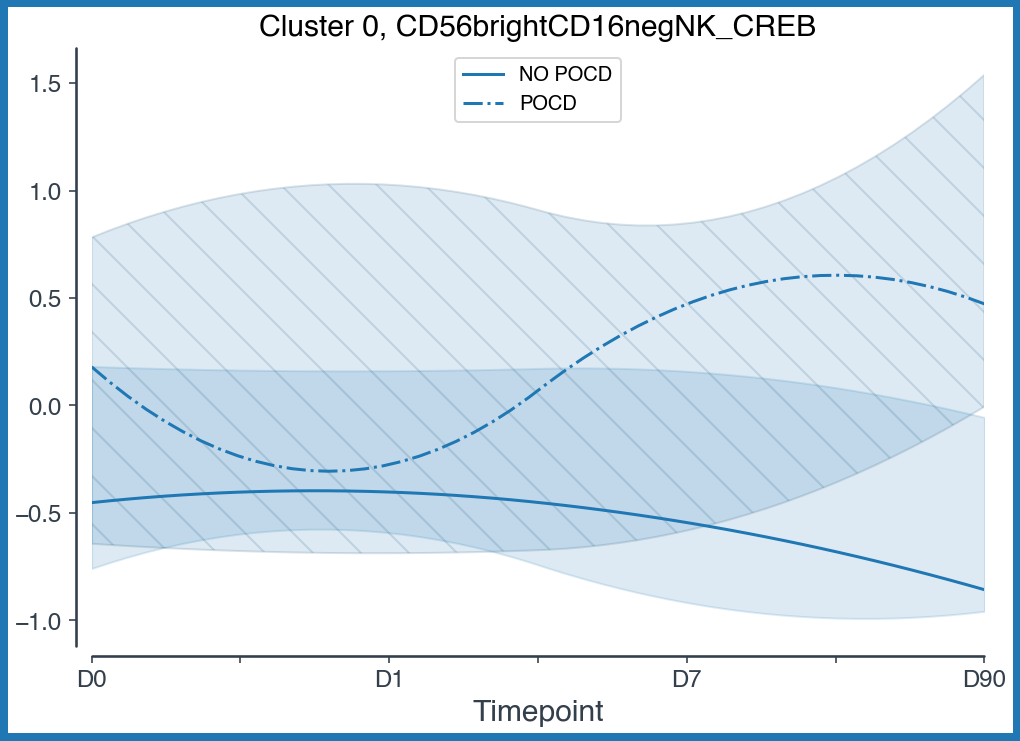

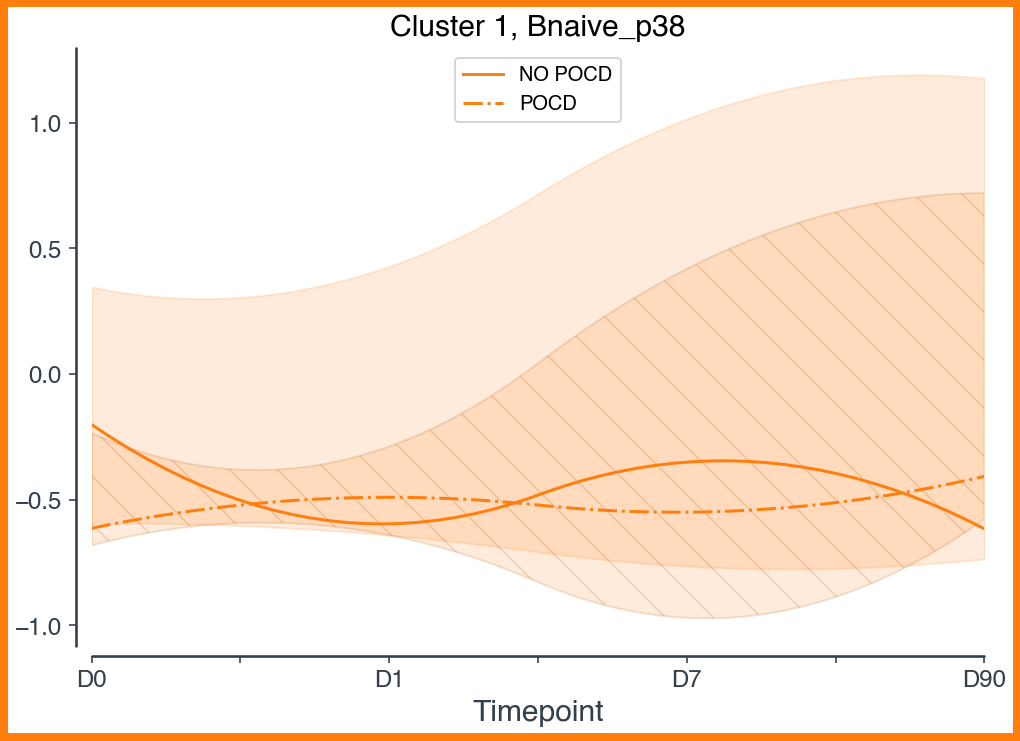

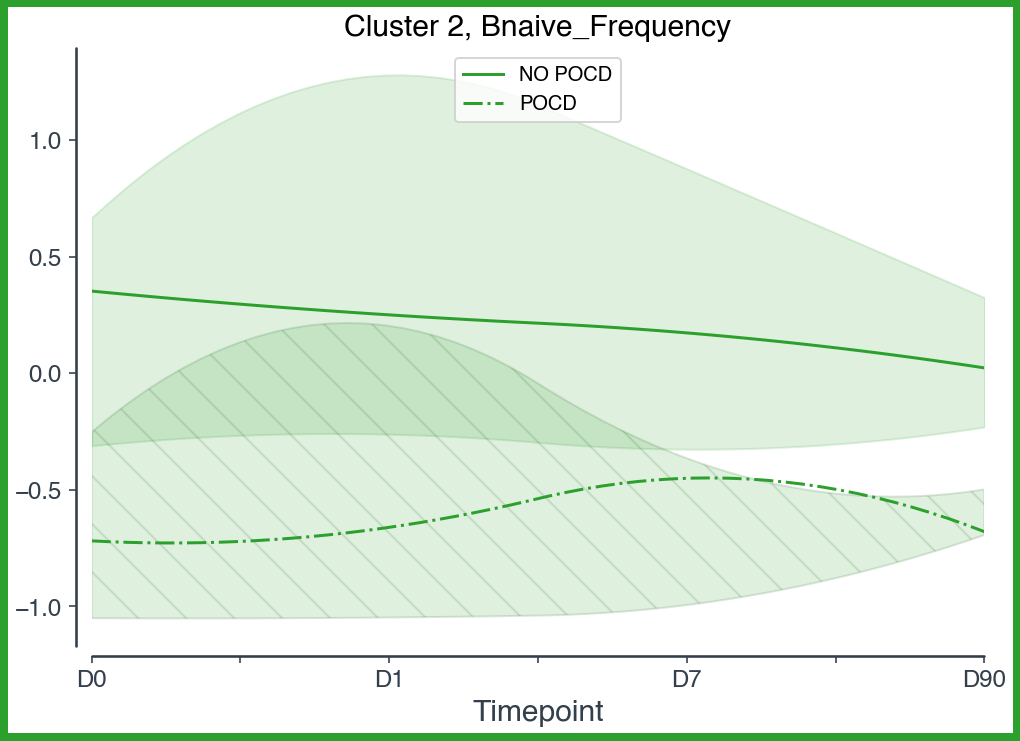

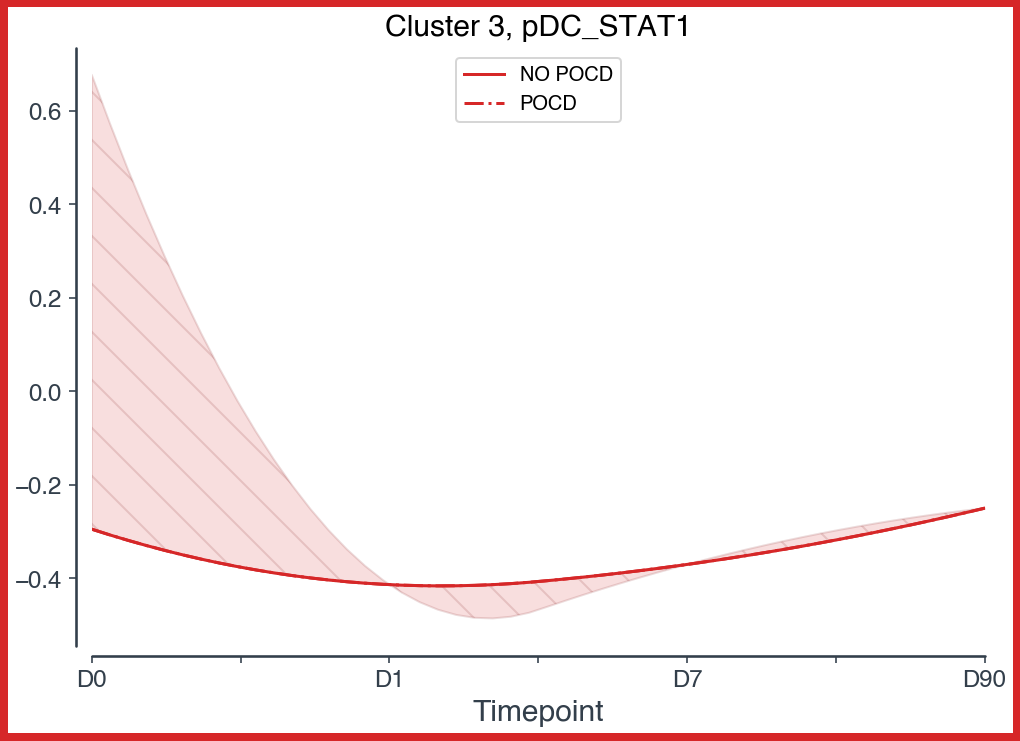

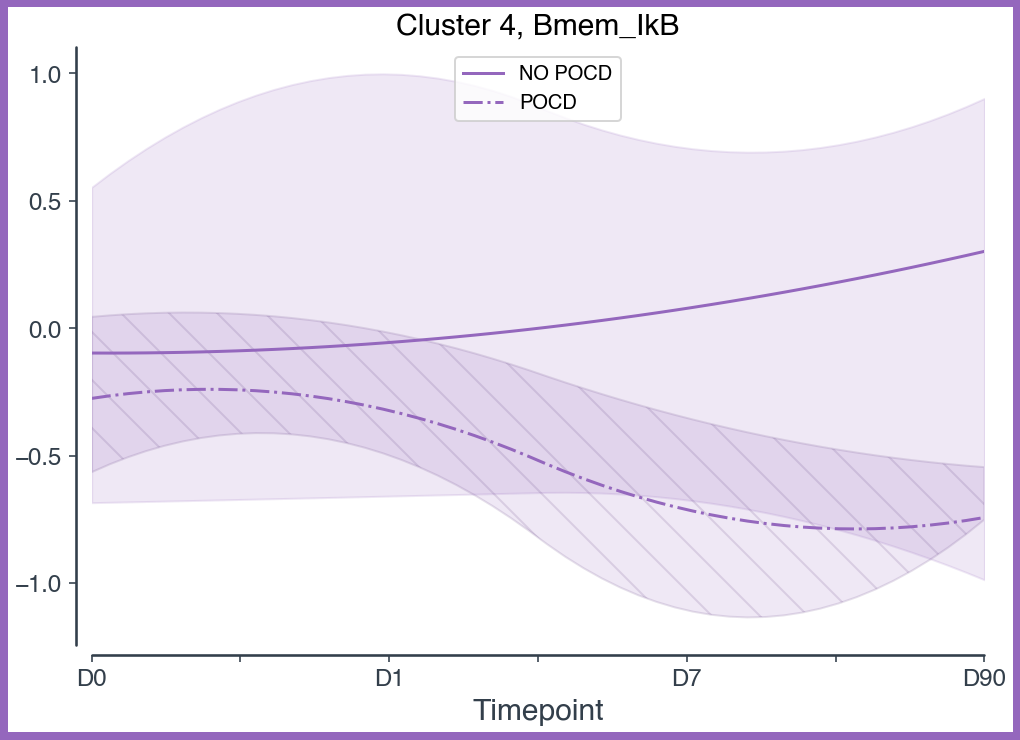

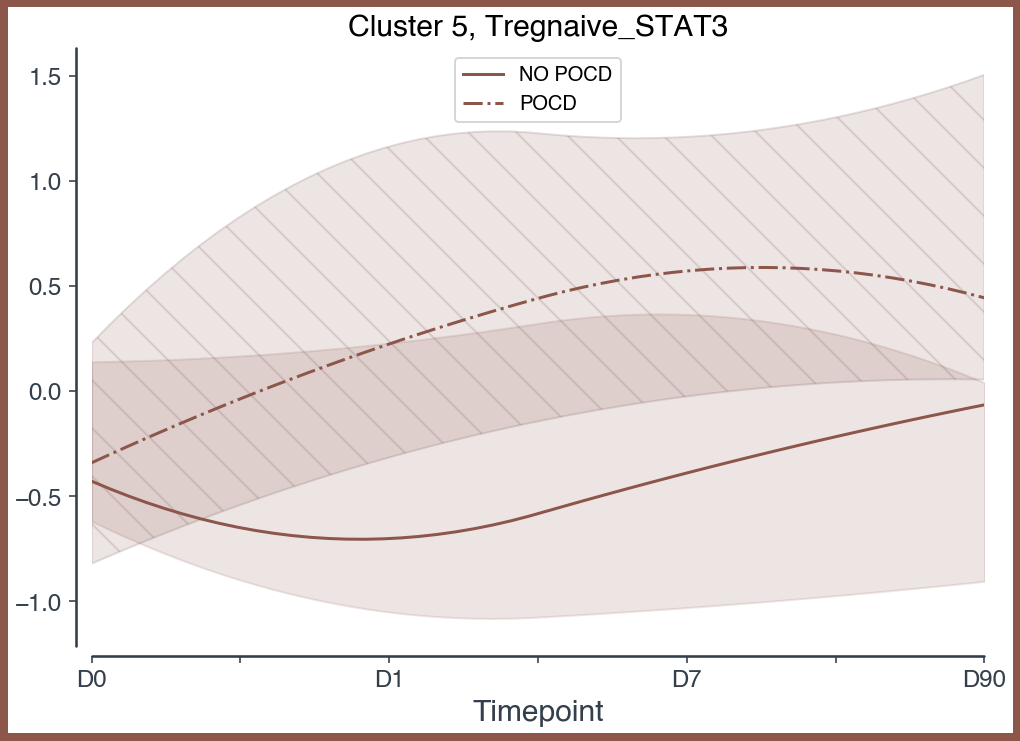

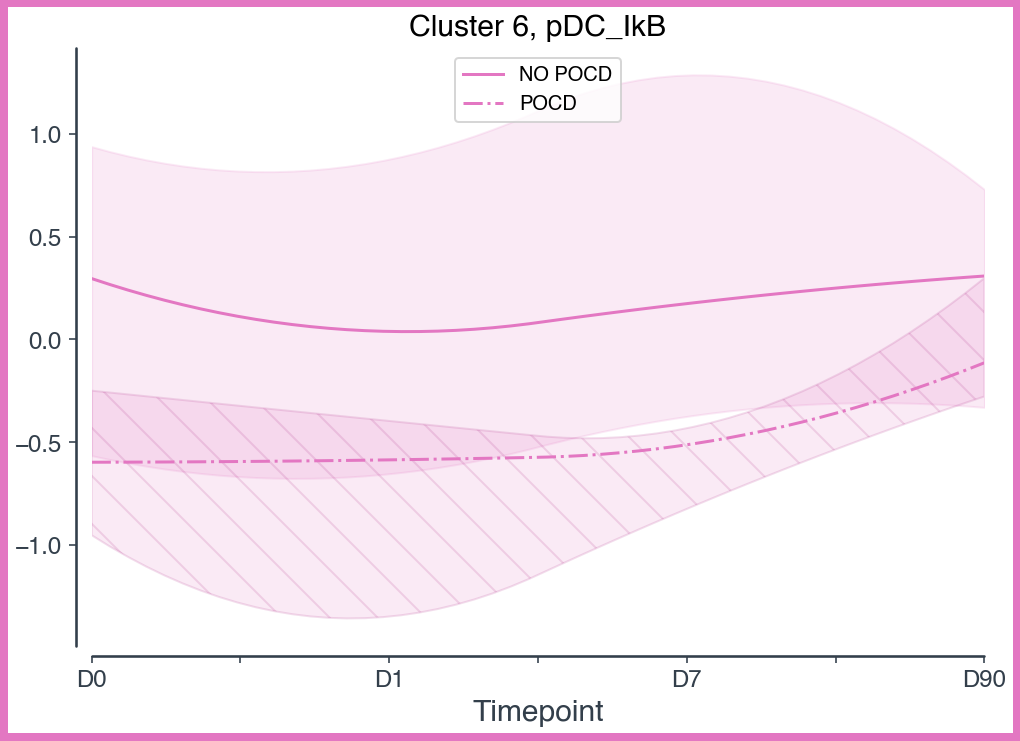

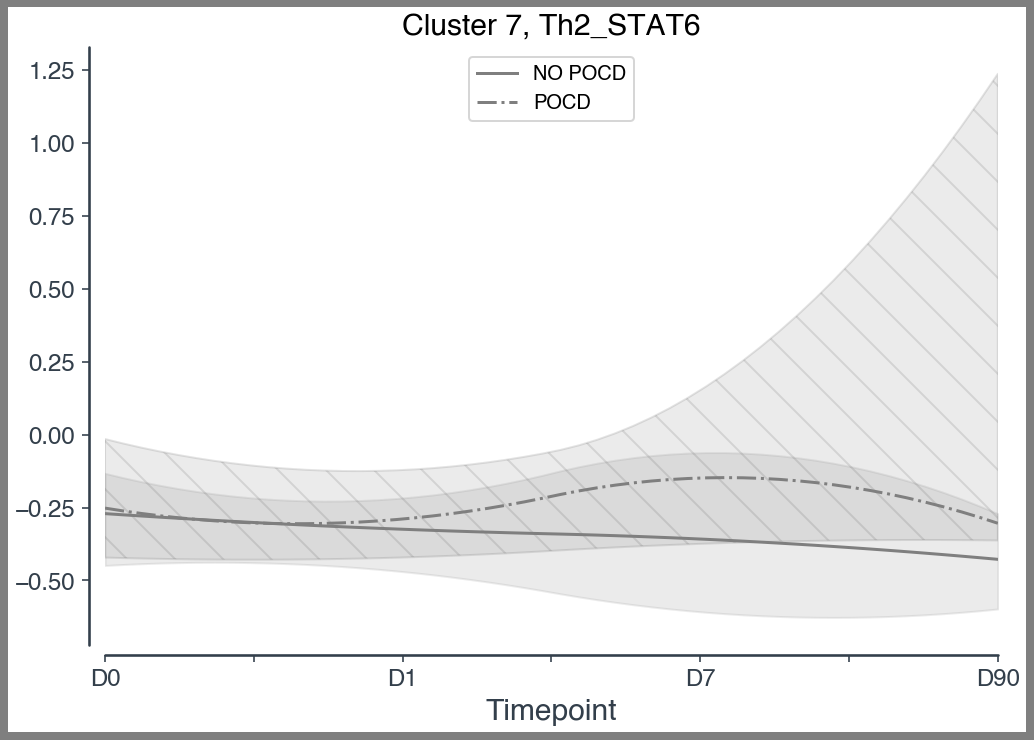

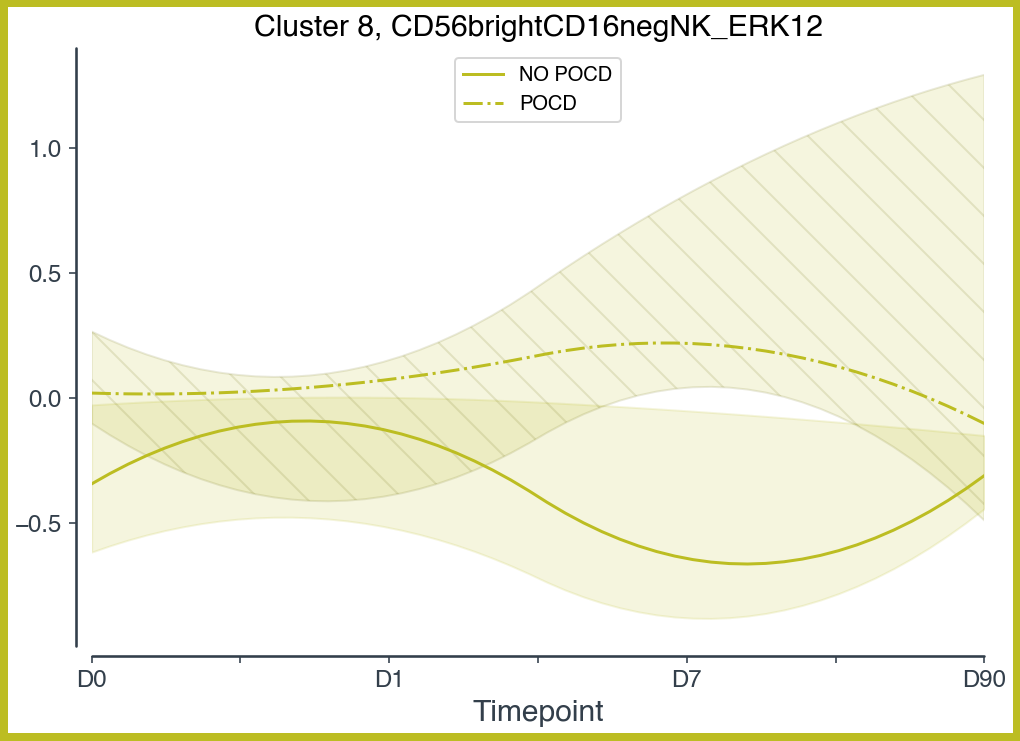

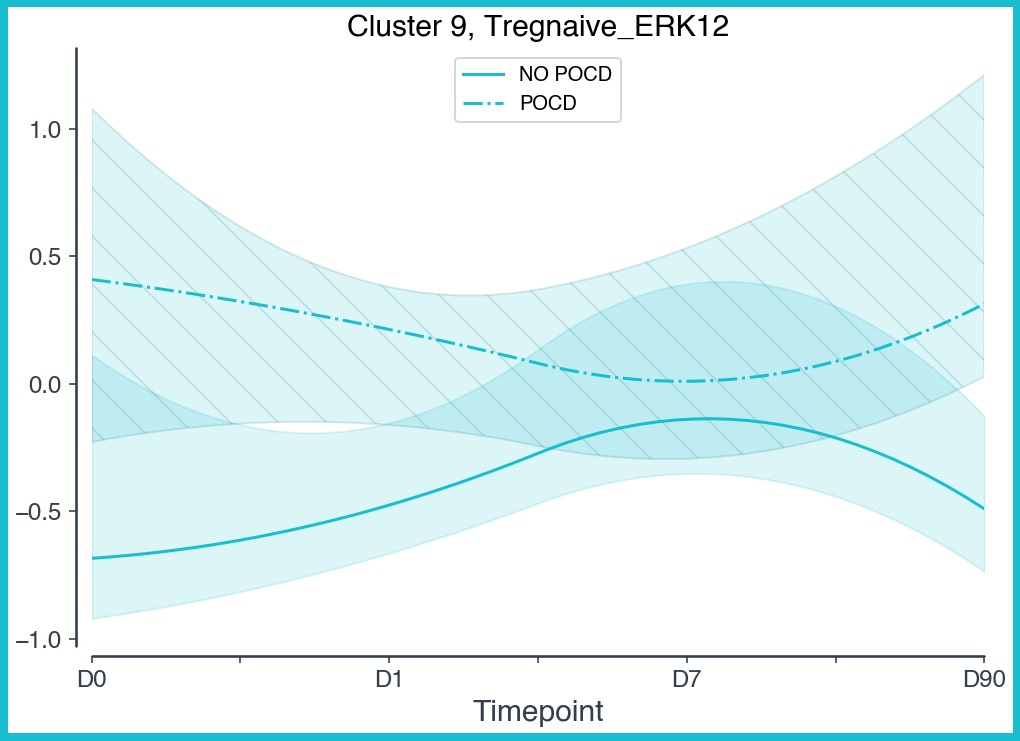

In [136]:
for i in np.unique(cluster_labels):
    fig,ax = plt.subplots(1, 1, figsize=(8,5.5), edgecolor='C'+str(i), linewidth=8)
    top_feature = df_tsne[df_tsne.cluster==i].pvalue_anova.idxmin()
    print(top_feature)
    control_medians = []
    control_q3, control_q1 = [], []
    
    pocd_medians = []
    pocd_q3, pocd_q1 = [], []

    for df, labels in [(D0_std, labels_D0),
                       (D1_std, labels_D1),
                       (D7_std, labels_D7),
                       (D90_std, labels_D90)]:
        
        control_values = df[labels.POCD_J7_pos==0][top_feature]
        control_medians.append(control_values.median())
        tmp_control_q3, tmp_control_q1 = np.nanpercentile(control_values, [75, 25])
        control_q1.append(tmp_control_q1)
        control_q3.append(tmp_control_q3)
        
        pocd_values = df[labels.POCD_J7_pos==1][top_feature]
        pocd_medians.append(pocd_values.median())
        tmp_pocd_q3, tmp_pocd_q1 = np.nanpercentile(pocd_values, [75, 25])
        pocd_q1.append(tmp_pocd_q1)
        pocd_q3.append(tmp_pocd_q3)
        
        
    x_new = np.linspace(0, 3, 50)

    control_med_feature_BSpline = make_interp_spline([0, 1, 2, 3],control_medians, k=2)
    pocd_med_feature_BSpline = make_interp_spline([0, 1, 2, 3], pocd_medians, k=2)

    y_control_feature = control_med_feature_BSpline(x_new)
    y_pocd_feature = pocd_med_feature_BSpline(x_new)

    ax.plot(x_new, y_control_feature,alpha=1, color='C'+str(i), label='NO POCD')
    ax.plot(x_new, y_pocd_feature,alpha=1,linestyle='-.',color='C'+str(i), label='POCD')    
    
    control_q3_BSpline = make_interp_spline([0, 1, 2, 3], control_q3, k=2)
    control_q1_BSpline = make_interp_spline([0, 1, 2, 3], control_q1, k=2)
    y_control_q3 = control_q3_BSpline(x_new)
    y_control_q1 = control_q1_BSpline(x_new)
    
    ax.fill_between(x_new, y_control_q3, y_control_q1, color='C'+str(i),alpha=.15,linestyle='-') 
    
    pocd_q3_BSpline = make_interp_spline([0, 1, 2, 3], pocd_q3, k=2)
    pocd_q1_BSpline = make_interp_spline([0, 1, 2, 3], pocd_q1, k=2)
    y_pocd_q3 = pocd_q3_BSpline(x_new)
    y_pocd_q1 = pocd_q1_BSpline(x_new)
   
    test = ax.fill_between(x_new, y_pocd_q3, y_pocd_q1, color='C'+str(i), alpha=.15)
    
    col = matplotlib.colors.to_rgb('C'+str(i))
    ax.set_title(f'Cluster {i}, {top_feature}', fontsize=15)
    
    test.set_hatch('\\')
    col = adjust_lightness('C'+str(i),.6)
    test.set_edgecolor(col)
    
    ax.spines[["top","right"]].set_visible(False)
    ax.spines[['left',"bottom"]].set_capstyle("round")
    ax.spines[['left',"bottom"]].set_linewidth(1.3)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticklabels(['D0', '', 'D1','','D7', '', 'D90'])
    ax.set_xlabel('Timepoint', fontsize=15, fontweight='black', color = '#333F4B')
    # add some space between the axis and the plot
    ax.set_xlim(0, 3)
    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.legend(loc='upper center')
    
    fig.savefig(f'./Correlation network - ANOVA/Top features Trajectories/Medians only/Cluster {i}, {top_feature} interp.pdf', dpi=250,edgecolor=fig.get_edgecolor())

# Annotation graph

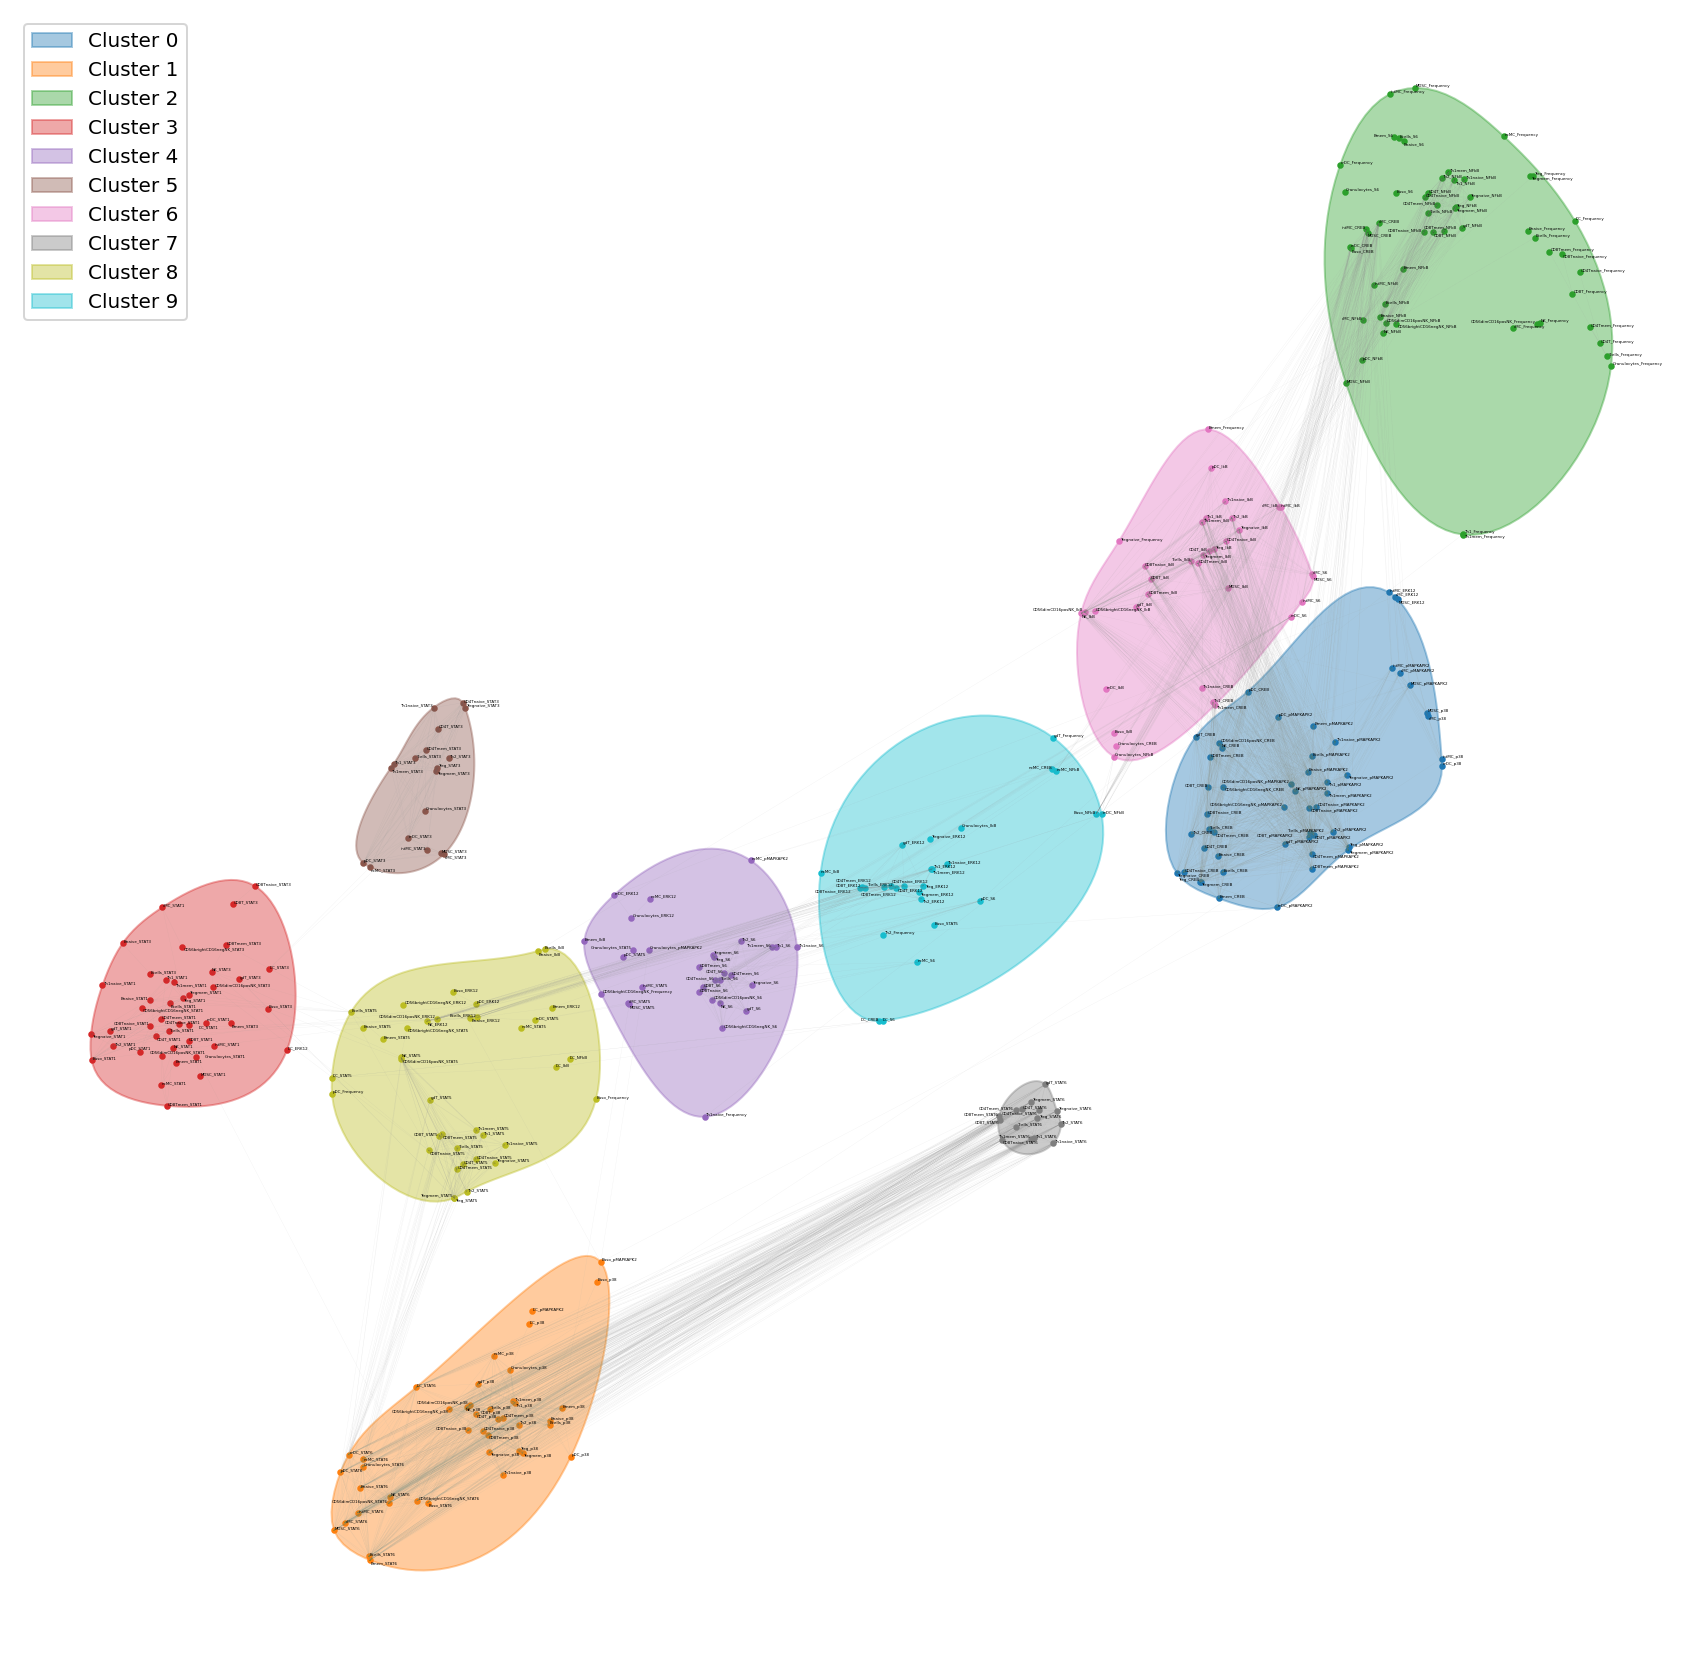

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
# --DRAWING CLUSTERS--

color =  ['C'+str(i) for i in np.unique(cluster_labels)]
# draw enclosure
for i in np.unique(cluster_labels):
    points = df_tsne[df_tsne.cluster == i][['coor1', 'coor2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    tck, _ = splprep([x_hull, y_hull], s=0, per = True)
    xx, yy = splev(np.linspace(0, 1, 100), tck, der = 0)
    
    # plot shape
    #plt.plot(xx, yy, alpha=1, linestyle='--', linewidth=.6,color='C'+str(i))
    plt.fill(xx, yy, alpha=.4, color=color[i], label=f'Cluster {i}')
    # --DRAWING POINTS--
    scatter = plt.scatter(df_tsne[df_tsne.cluster ==i].coor1,
                     df_tsne[df_tsne.cluster==i].coor2, 
                     s=5, 
                     c=color[i],
                     marker='o',
                     edgecolors=None,
                     cmap=cmap,
                     alpha=1
                    )
    
for i in df_tot.columns:
    for j in df_tot.columns:
        if df_corr.loc[i,j]>=CORR_THRESH and df_corr.loc[i,j] < 1:
            sub_df = df_tsne.loc[[i, j]]
            ax.plot(sub_df.coor1, sub_df.coor2, linewidth=.2,color='gray', alpha=.05)
ax.axis("off")

annot=[]        
for i, txt in enumerate(df_tsne.index):
    annot.append(ax.annotate(txt, (df_tsne.iloc[i].coor1, df_tsne.iloc[i].coor2), fontsize=2))
        
adjust_text(annot)
plt.legend()
fig.savefig('./Correlation networks/annot_cluster.pdf', dpi=95)